# Add an Image: Editor Retention

We investigate the effect of having Add an Image as the default task on whether a newcomer returns to edit again within two weeks depending on whether they edited during the first 24 hours.

Summary of findings:

When measuring retention as a result of activation by controlling for first-day activity, we find no difference in the retention rate between the three experiment groups. When we add data from the French Wikipedia and compare Add an Image to Add a Link, we also find no difference in retention rates between them. This result is consistent across our two different namespace conditions (all namespaces and Article & Talk) and whether we use all edits or only non-reverted ones.

When we focus on non-reverted edits in the Article & Talk namespaces ("constructive article retention") and remove the first-day activity control, meaning we measure retention from all registrations, then we find an increase in retention on mobile web for both structured tasks. We do not find a significant increase on desktop. The increase in retention on mobile web comes through the increases in activation caused by the structured tasks followed by a similar retention rate of activated users. The lack of a significant increase on desktop can be explained by the smaller effect size (average effect is roughly +10% in the graph for Add a Link) combined with the small proportions (around 3%).

In [1]:
library(tidyverse)
library(broom)

# library(brms) # install.packages("brms")
# library(loo) # install.packages("loo")
# library(rstanarm) # install.packages("rstanarm")

library(lubridate)
library(bayesplot)

library(lme4)
library(yardstick) # install.packages("yardstick")

library(caret)

Warning message:
“package ‘tidyverse’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
Warning message:
“package ‘lubridate’ was built under R version 4.2.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()

# R Configuration variables

In [2]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

Warning message:
“package ‘RhpcBLASctl’ was built under R version 4.2.3”


# Helper functions

In [3]:
## Function that takes in a model, the validation set, the name of the predicted column,
## and returns a plot of the ROC curve
plot_ROC <- function(mod, val_data, col_name) {
    val_data$estimate = predict(mod, val_data, type = "response")
    roc_curve(val_data, {{ col_name }}, estimate, event_level = 'second') %>%
        ggplot(aes(x = 1 - specificity, y = sensitivity)) +
        geom_path() +
        geom_abline(lty = 3) +
        coord_equal() +
        theme_bw()
}

In [4]:
## Function that takes in the filename of the user edit data, reads it in,
## and creates all the various derived columns we need.
read_user_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = user_dataset_column_types) %>%
    mutate(
        Group = factor(hp_enabled, levels = c(0, 1), labels = c("C", "HP")),
        platform = factor(reg_on_mobile == 1, c(FALSE, TRUE), c("desktop", "mobile")),
        ## Registration month, for later joins on month
        reg_month = floor_date(user_registration_timestamp, unit = 'month'),
        # Number of edits:
        num_total_edits_24hrs = num_article_edits_24hrs + num_other_edits_24hrs,
        num_total_edits_2w = num_article_edits_2w + num_other_edits_2w,
        num_total_edits = num_total_edits_24hrs + num_total_edits_2w,
        num_total_article_edits = num_article_edits_24hrs + num_article_edits_2w,
        num_total_other_edits = num_other_edits_24hrs + num_total_edits_2w,
        # Log number of total edits is used as a control variable in the revert analysis
        log_num_total_edits = log(1 + num_total_edits),
        # Number of reverts:
        num_reverts_24hrs = num_article_reverts_24hrs + num_other_reverts_24hrs,
        num_reverts_2w = num_article_reverts_2w + num_other_reverts_2w,
        num_total_reverts = num_reverts_24hrs + num_reverts_2w,
        ## Control variables for the number of edits made (used for ex. in revert analysis)
        log_num_article_edits_24hrs = log(1 + num_article_edits_24hrs),
        log_num_other_edits_24hrs = log(1 + num_other_edits_24hrs),
        log_num_edits_24hrs = log(1 + num_article_edits_24hrs + num_other_edits_24hrs),
        # Control variables for the number of constructive edits made
        log_num_const_article_edits_24hrs = log(
            1 + num_article_edits_24hrs - num_article_reverts_24hrs),
        log_num_const_other_edits_24hrs = log(
            1 + num_other_edits_24hrs - num_other_reverts_24hrs),
        log_num_const_edits_24hrs = log(
            1 + num_article_edits_24hrs + num_other_edits_24hrs -
                num_article_reverts_24hrs - num_other_reverts_24hrs),
        # Revert rate:
        prop_rev_edits = ifelse(num_total_edits > 0, num_total_reverts / num_total_edits, 0),
        # Did they activate?
        is_activated_article = num_article_edits_24hrs > 0,
        is_activated_other = num_other_edits_24hrs > 0,
        is_activated = is_activated_article | is_activated_other,
        # Did they activate through constructive edits?
        is_const_activated_article = (num_article_edits_24hrs - num_article_reverts_24hrs) > 0,
        is_const_activated_other = (num_other_edits_24hrs - num_other_reverts_24hrs) > 0,
        is_const_activated = is_const_activated_article | is_const_activated_other,
        # Were they retained?
        is_retained_article = is_activated_article & (num_article_edits_2w > 0),
        is_retained_other = is_activated_other & (num_other_edits_2w > 0),
        is_retained = is_activated & ((num_article_edits_2w + num_other_edits_2w) > 0),
        # Were they retained through constructive edits?
        is_const_retained_article = is_const_activated_article &
            ((num_article_edits_2w - num_article_reverts_2w) > 0),
        is_const_retained_other = is_const_activated_other &
            ((num_other_edits_2w - num_other_reverts_2w) > 0),
        is_const_retained = is_const_activated &
            ((num_article_edits_2w + num_other_edits_2w -
              num_article_reverts_2w - num_other_reverts_2w) > 0)
    ) 
}

In [5]:
## Function that takes in the filename of the active editors dataset,
## and adds a registration month column for easy joining with the user dataset.
read_active_editors_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = active_editors_column_types) %>%
    mutate(wiki_db = factor(wiki_db),
           reg_month = month + months(1))
}

# Experiment Configuration Variables

We define a set of configuration variables that are useful for the analysis. One obvious one is where the edit dataset is located.

A less obvious one is a variable for when the experiment started. We often use this seeking to model the community's initial response to changes in newcomer behaviour, as well as long-term trends in the outcome variable when working with user data gathered across a relatively long time period.

In [6]:
## Path to the datasets with user edits
user_dataset_filenames <- c(
    '/home/nettrom/src/2021-Growth-structured-tasks/datasets/add-an-image-edit-data.tsv'
    )

## Column types in the dataset: wiki is a factor, HP variant is a factor, registration is a date time,
## everything else are integers.
user_dataset_column_types <- 'fiTiifiiiiiiii'

## Path to the dataset with counts of the number of active editors
active_editors_filenames <- c()

## Column types in the active editors dataset: month is a date, wiki is a factor
active_editors_column_types <- 'Dfiii'

## Deployment timestamps for Add an Image on each of the wikis
## This is not relevant for this, because we "reset" the experiment and
## gather data well after deployment.
exp_start_timestamps <- tribble(
    ~wiki_db, ~exp_start_timestamp,
    'arwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),

) %>% mutate(wiki_db = factor(wiki_db))

## Path to the dataset with editing status at account registration
editing_status_filenames <- c()

## Column types in the editing status dataset: wiki is a factor, everything else are integers
editing_status_column_types <- 'fii'

## Path to the dataset with Welcome Survey responses
survey_response_filenames <- c()

## Columns types in the survey response data: user ID is an integer, number of languages is a number,
## everything else are factors
survey_response_column_types <- 'fifffn'

# Data import and setup

In [7]:
user_edit_data <- map_dfr(user_dataset_filenames, read_user_dataset)

In [8]:
nrow(user_edit_data)

[1] 148419

## Time since experiment start

Join the edits data with the experiment timestamps and measure time since the start to enable controlling for that:

Made sure that we're not dropping any users at this stage, we're good to move forward.

## Additional variables

We've previously focused on Control vs Growth Features in our analysis. In this case we'll focus primarily on Unstructured Link Task vs Add a Link, but also check against the control group. This means we want the single variable `Group` to reflect one of three options depending on `hp_enabled` and `hp_variant`

In [9]:
user_edit_data <- user_edit_data %>%
    mutate(
        platform = ifelse(reg_on_mobile == 1, 'Mobile web', 'Desktop'),
        exp_group = factor(
            ifelse(
                hp_enabled == 0, 'Control',
                ifelse(hp_variant == 'control',
                       'Add-a-Link', 'Add-an-Image')
            ),
            c('Control', 'Add-a-Link', 'Add-an-Image')
        )
    )

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [ ]:
user_edit_data %>%
    group_by(wiki_db, exp_group) %>%
    summarize(n = n())

**Note:** As we identified in the activation analysis, the French Wikipedia deployment did not use a control group. We therefore will have to exclude that wiki for any three-way analysis, but we can include it when we compare Add-an-Image to Add-a-Link.

## Splitting into Training, Test, and Validation Datasets

Split the dataset into training, test, and validation data sets.

In [10]:
## set the random seed so train/test/validation splits can be reproduced
set.seed(42)

trainIndex <- caret::createDataPartition(user_edit_data$Group,
                                         p = .8,
                                         list = FALSE,
                                         times = 1)
user_data_train = user_edit_data[trainIndex,]
user_data_second = user_edit_data[-trainIndex,]

testIndex = caret::createDataPartition(user_data_second$Group, p = .5, list = FALSE, times = 1)

user_data_test = user_data_second[testIndex,]
user_data_validate = user_data_second[-testIndex,]

In [11]:
user_data_test$is_activated_fct <- factor(user_data_test$is_activated,
                                          labels = c('No', 'Yes'))
user_data_validate$is_activated_fct <- factor(user_data_validate$is_activated,
                                          labels = c('No', 'Yes'))

## Visualizing Retention

We'll plot bar charts for retention for the Control, Unstructured, and Add-a-Link user groups.

### Retention

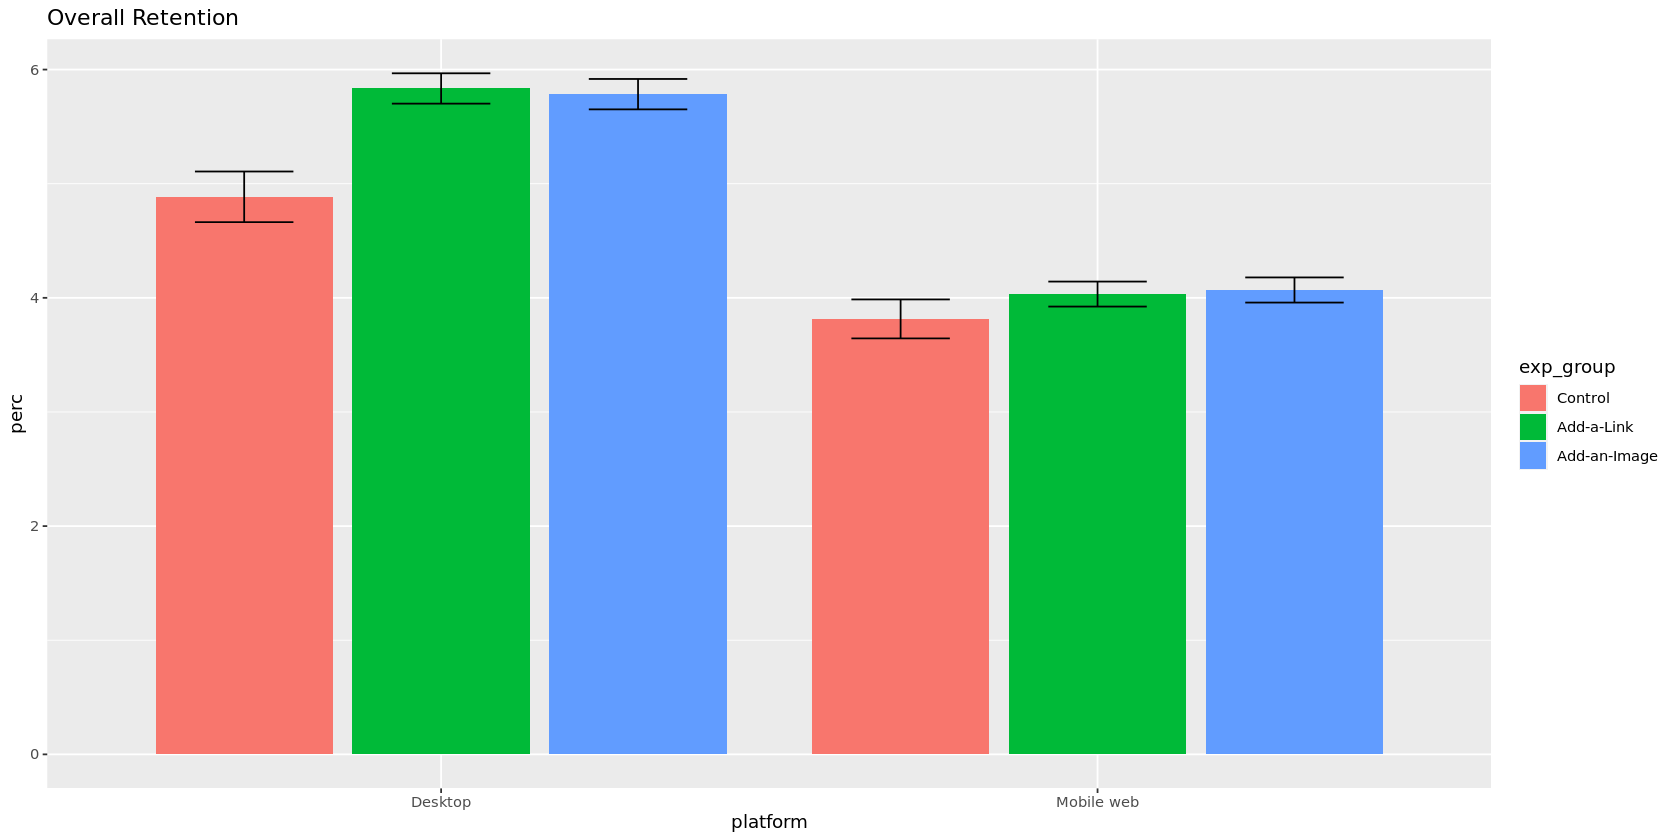

In [13]:
user_edit_data |>
    filter(wiki_db != 'frwiki') |>
    group_by(platform, exp_group, is_retained) |>
    tally() |>
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_retained == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = exp_group)) +
        labs(title = 'Overall Retention') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

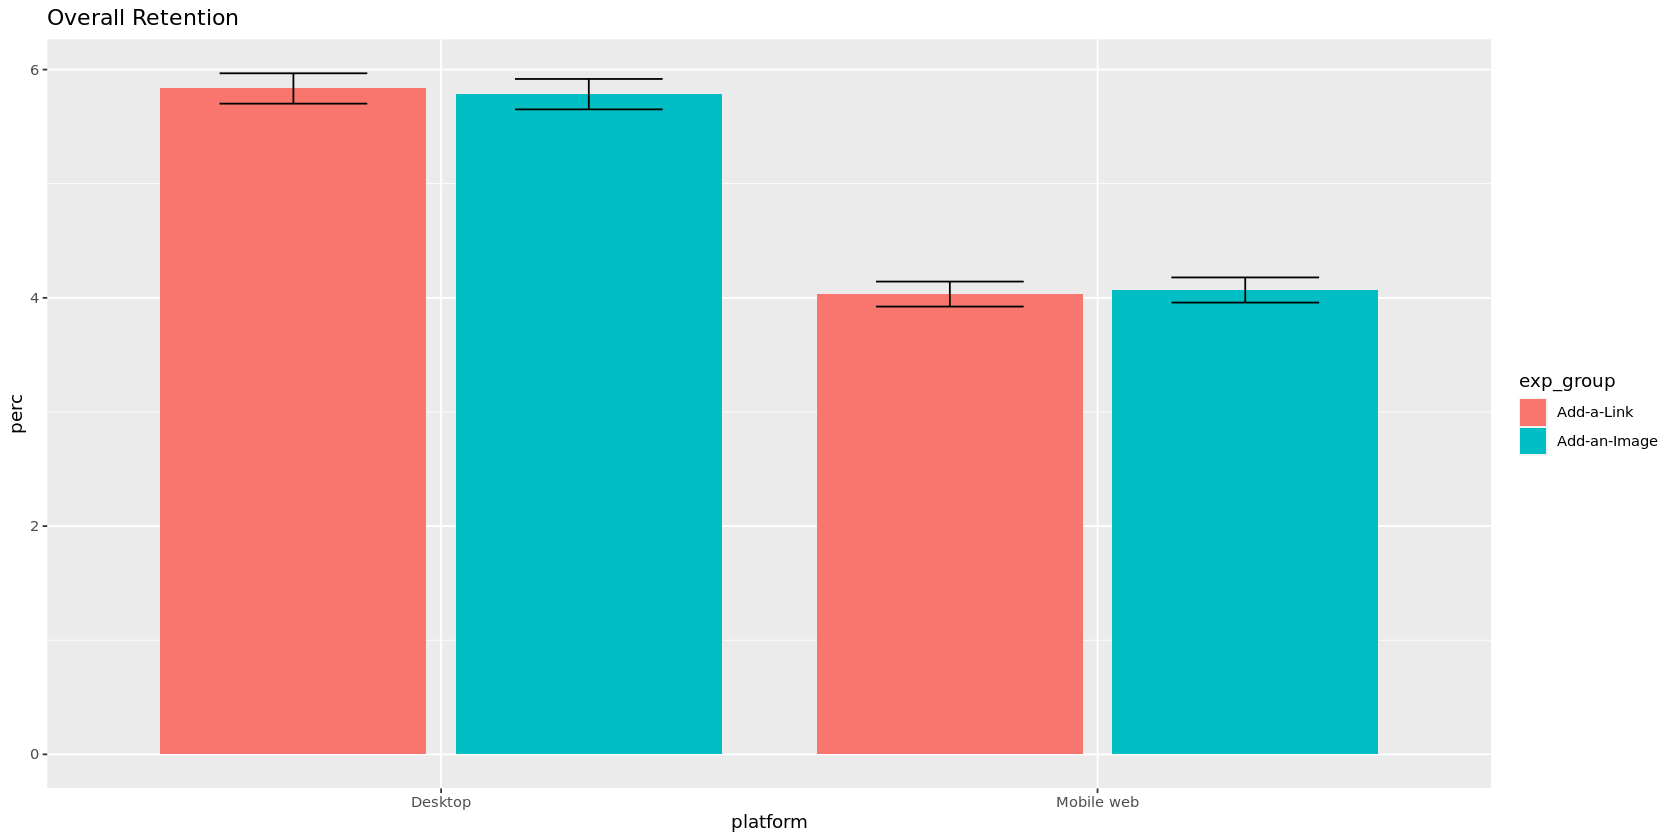

In [14]:
user_edit_data |>
    filter(exp_group != 'Control') |>
    group_by(platform, exp_group, is_retained) |>
    tally() |>
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_retained == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = exp_group)) +
        labs(title = 'Overall Retention') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

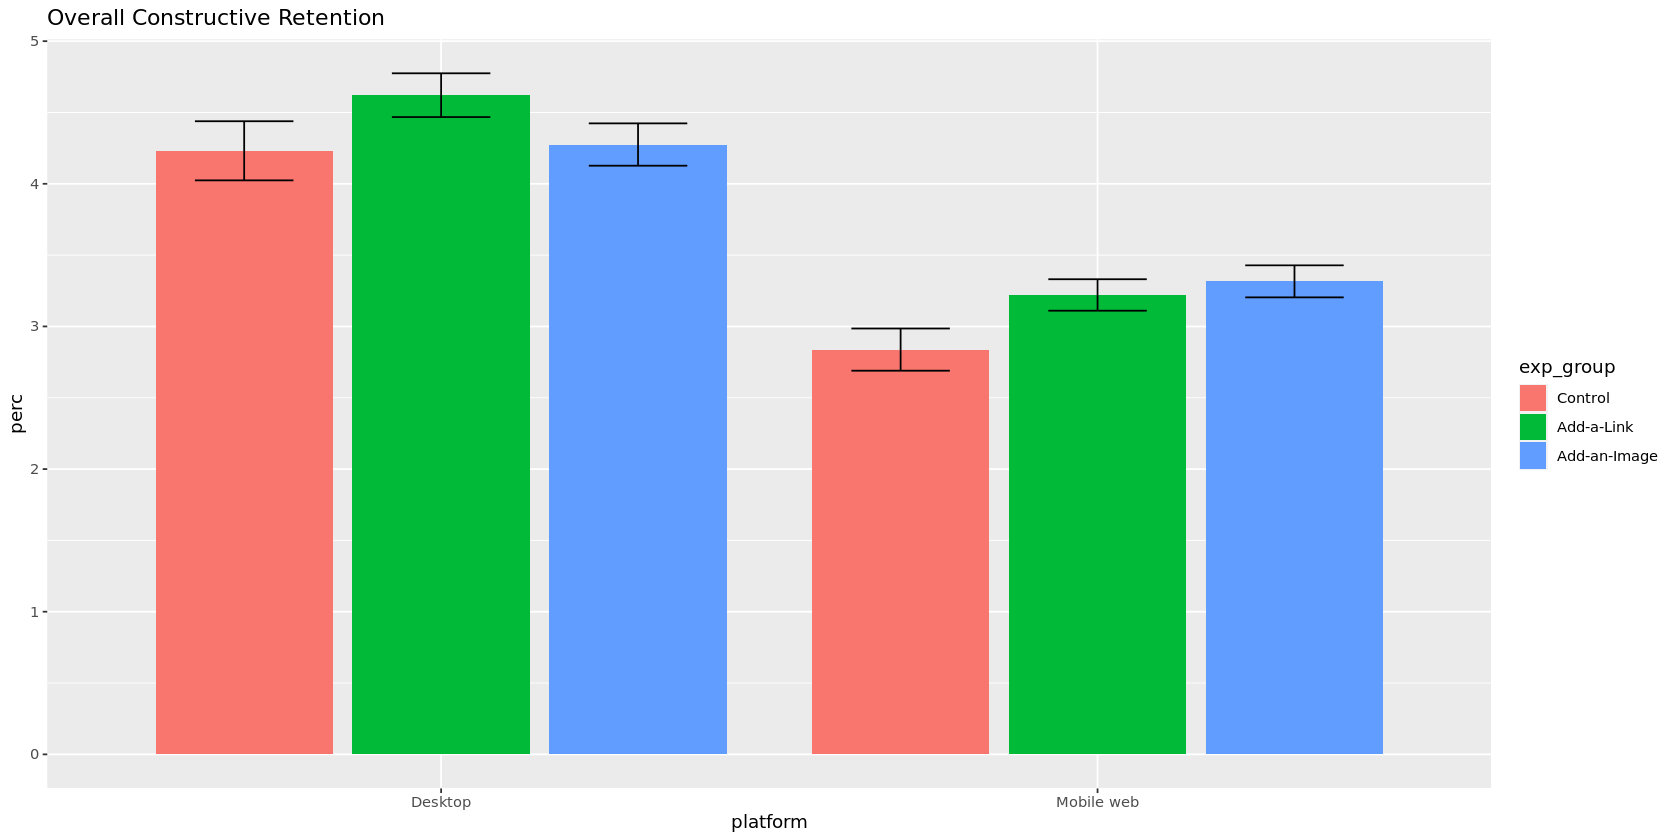

In [16]:
user_edit_data |>
    filter(wiki_db != 'frwiki') |>
    group_by(platform, exp_group, is_const_retained) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_retained == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = exp_group)) +
        labs(title = 'Overall Constructive Retention') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

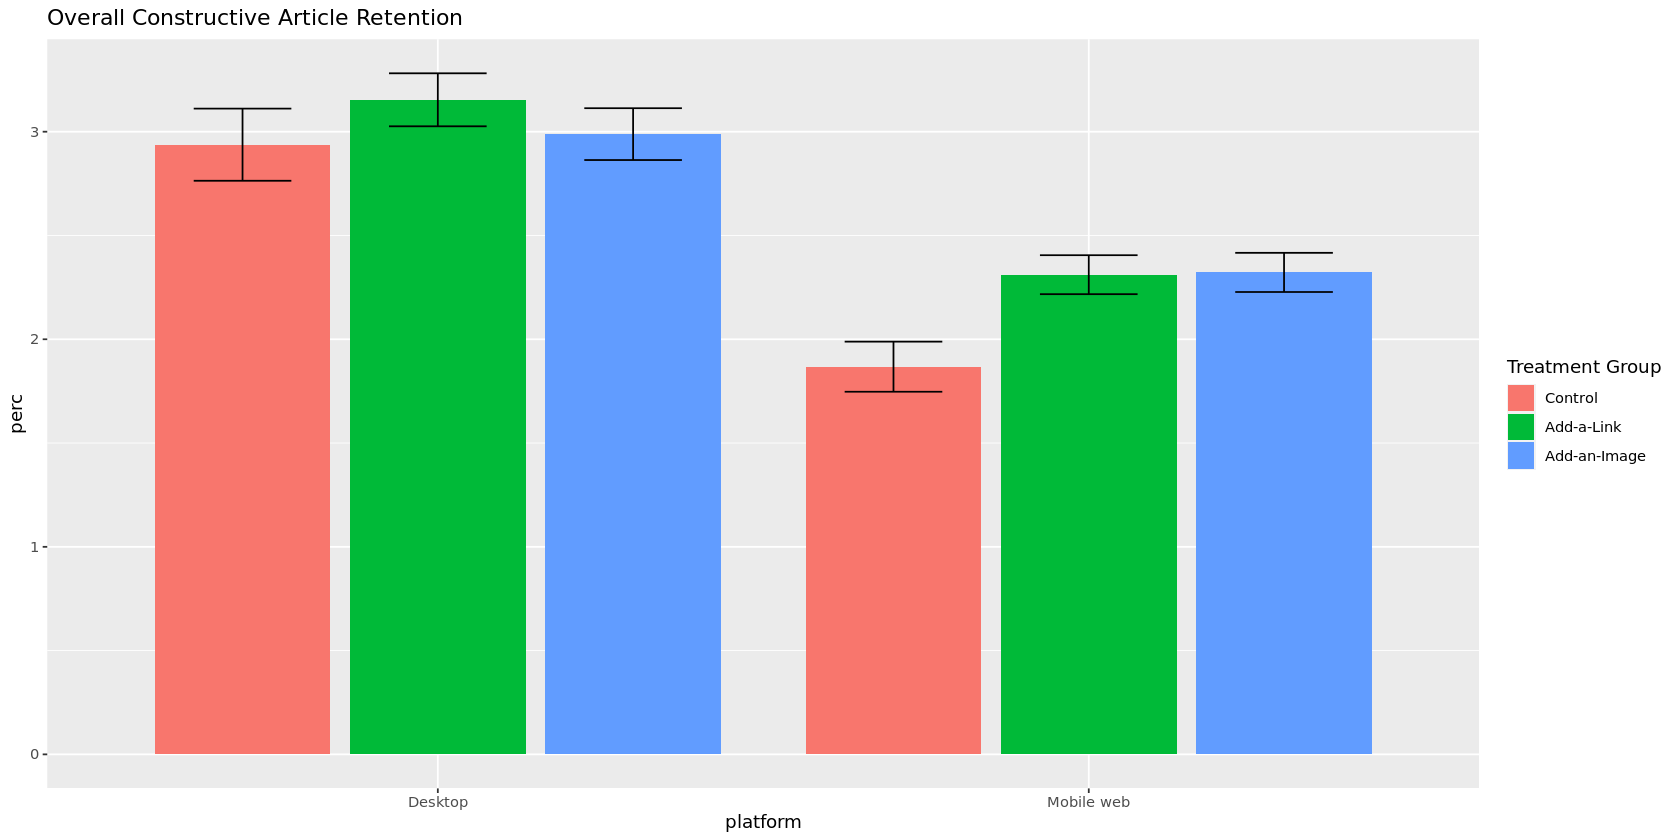

In [17]:
user_edit_data |>
    filter(wiki_db != 'frwiki') |>
    group_by(platform, exp_group, is_const_retained_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_retained_article == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = exp_group)) +
        labs(title = 'Overall Constructive Article Retention') +
        scale_fill_discrete(name = "Treatment Group") +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

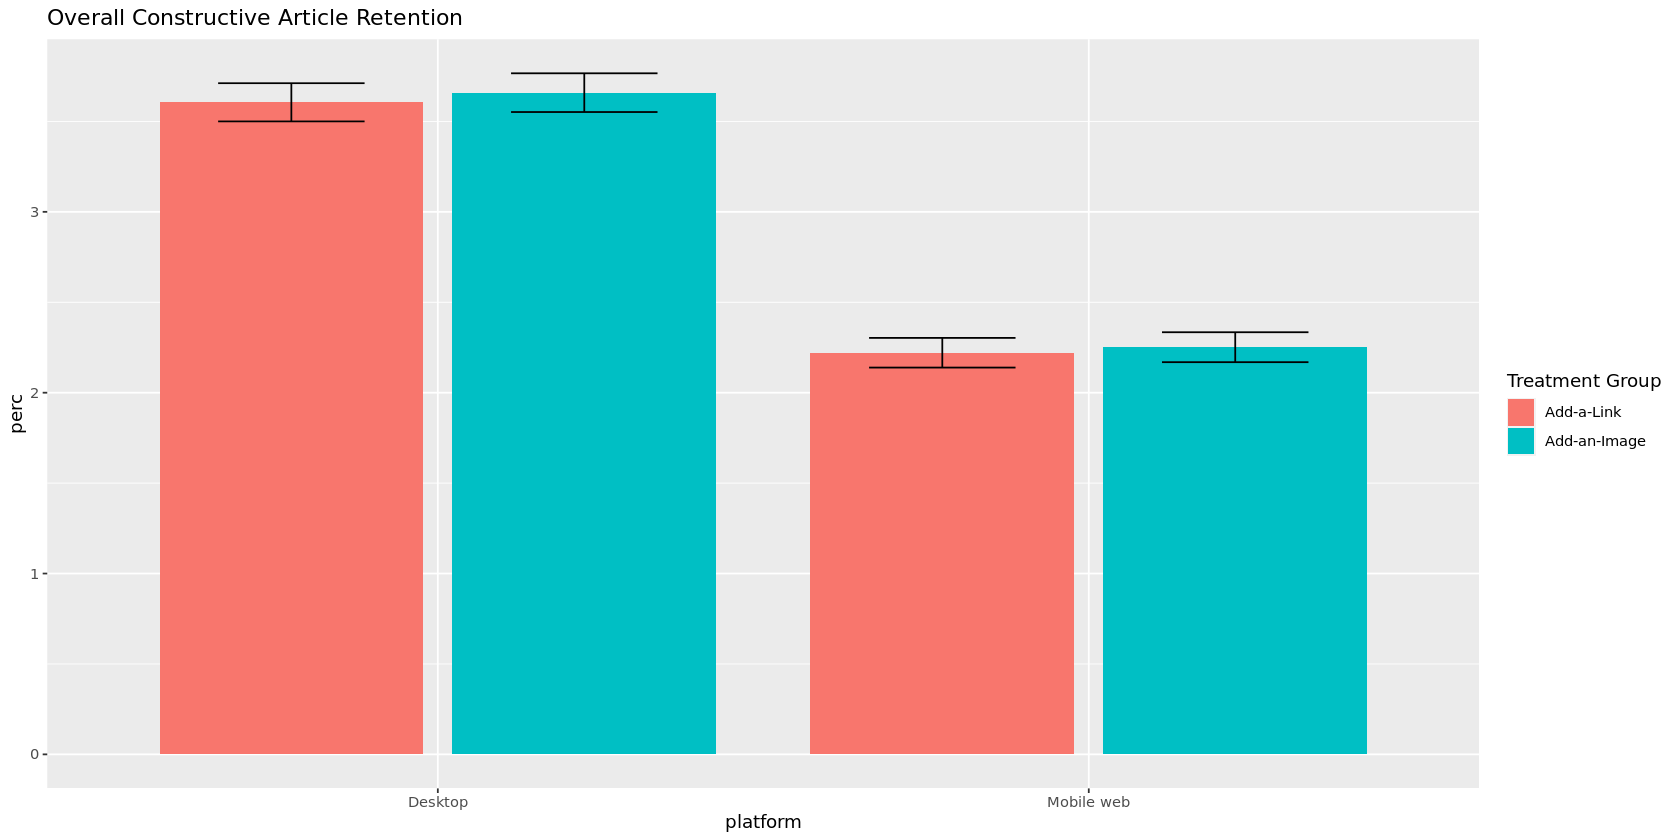

In [18]:
user_edit_data |>
    filter(exp_group != 'Control') |>
    group_by(platform, exp_group, is_const_retained_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_retained_article == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = exp_group)) +
        labs(title = 'Overall Constructive Article Retention') +
        scale_fill_discrete(name = "Treatment Group") +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

### Retention Based on Activation

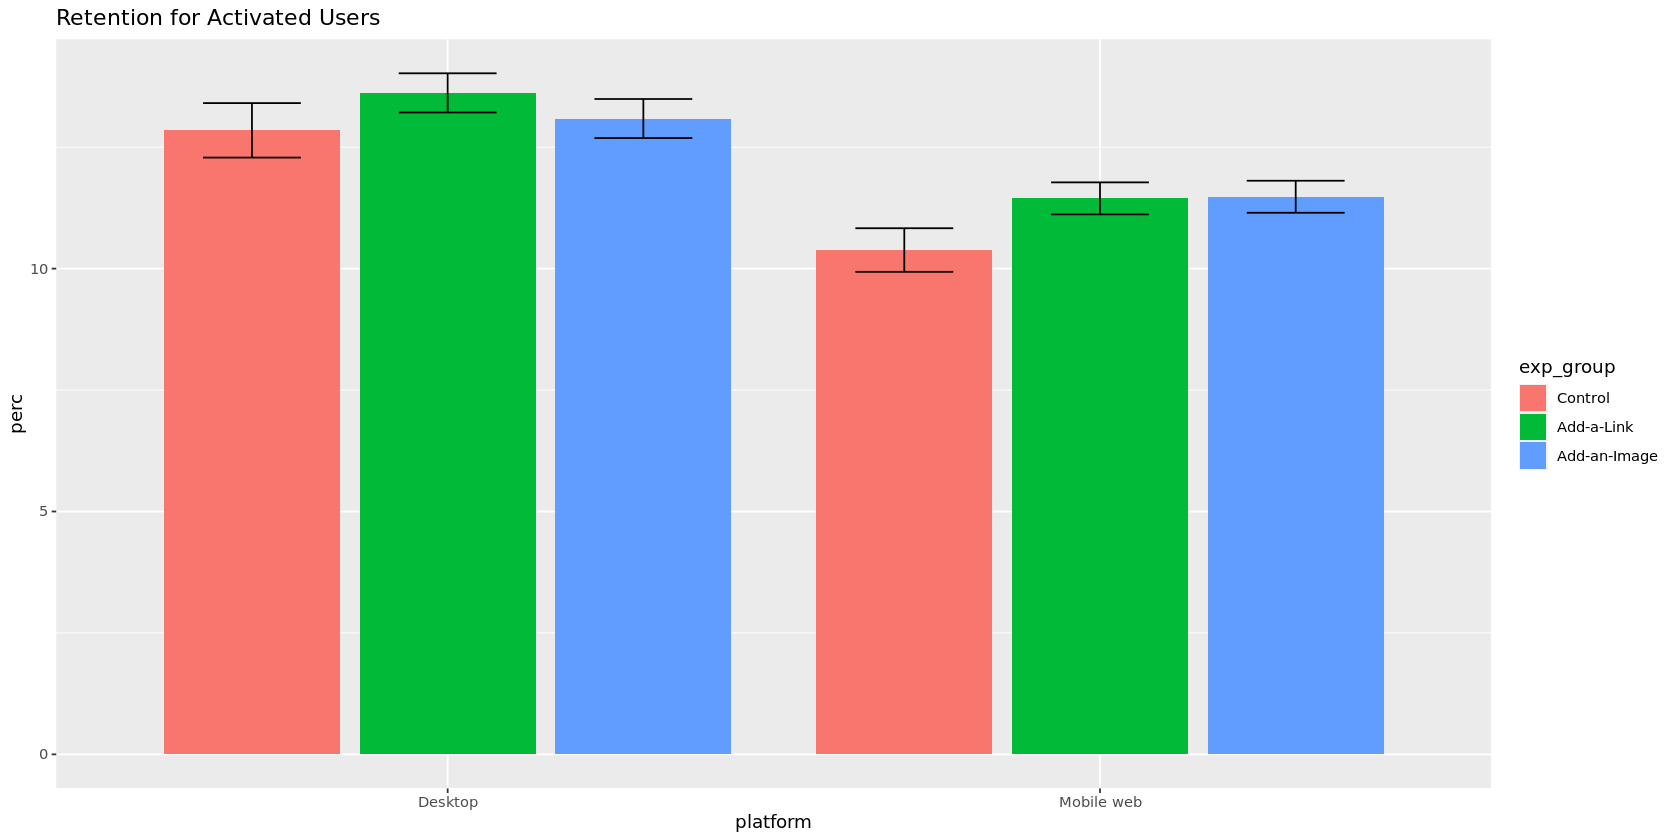

In [19]:
user_edit_data %>%
    filter(
        (wiki_db != 'frwiki') &
        (is_activated == TRUE)
    ) %>%
    group_by(platform, exp_group, is_retained) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_retained == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = exp_group)) +
        labs(title = 'Retention for Activated Users') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

In [ ]:
user_edit_data %>%
    filter(is_activated_article == TRUE) %>%
    group_by(platform, Group, is_retained_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_retained_article == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = Group)) +
        labs(title = 'Article Retention for Activated Users') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

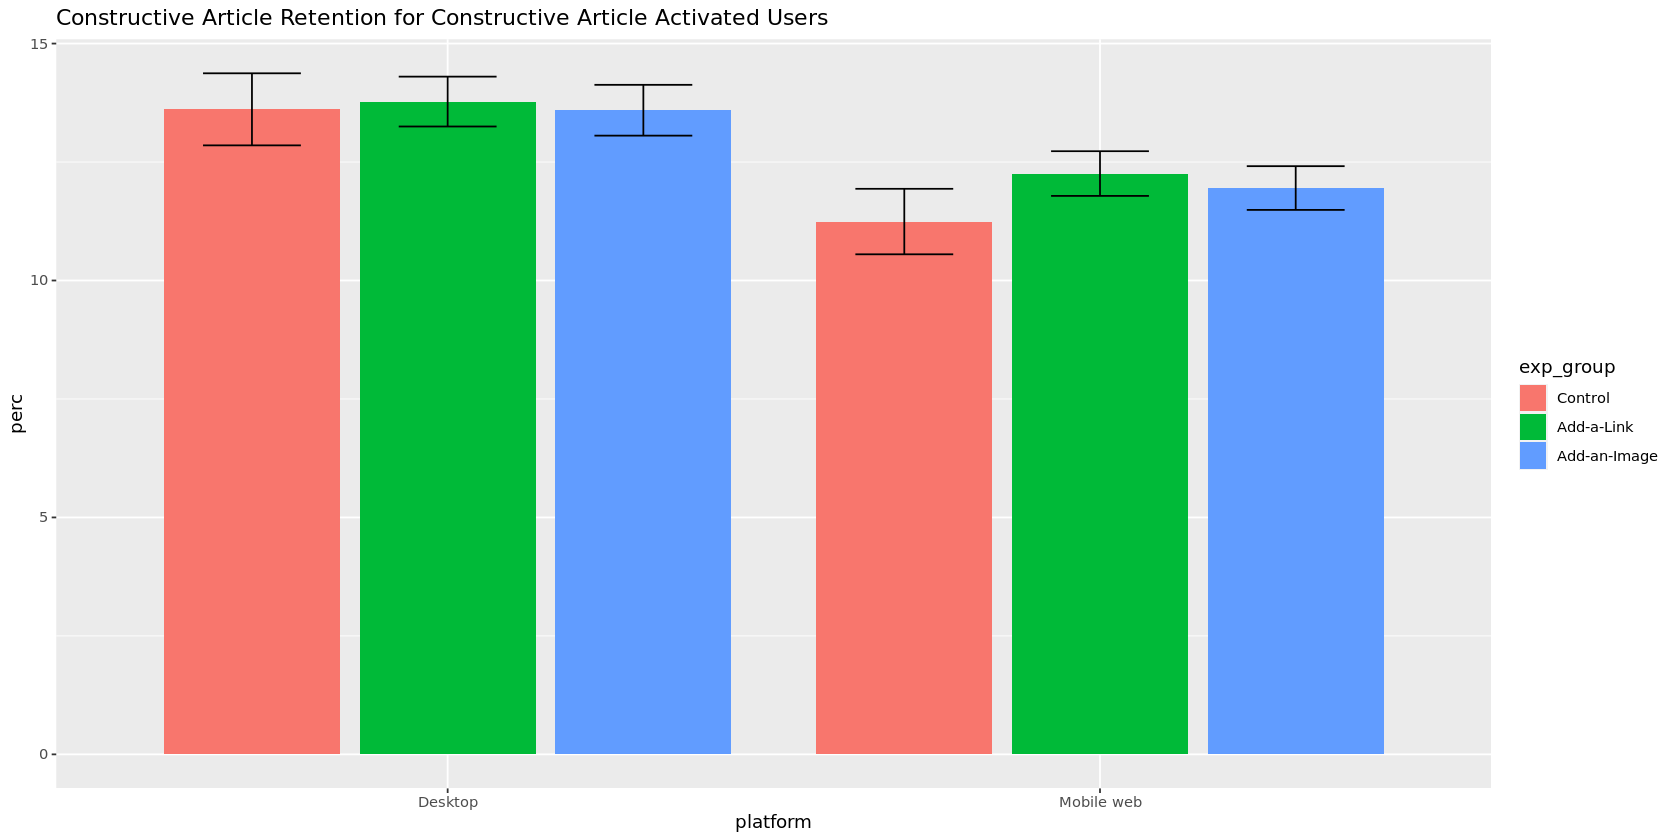

In [20]:
user_edit_data %>%
    filter(
        (wiki_db != 'frwiki') &
        (is_const_activated_article == TRUE)
    ) %>%
    group_by(platform, exp_group, is_const_retained_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_retained_article == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = exp_group)) +
        labs(title = 'Constructive Article Retention for Constructive Article Activated Users') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

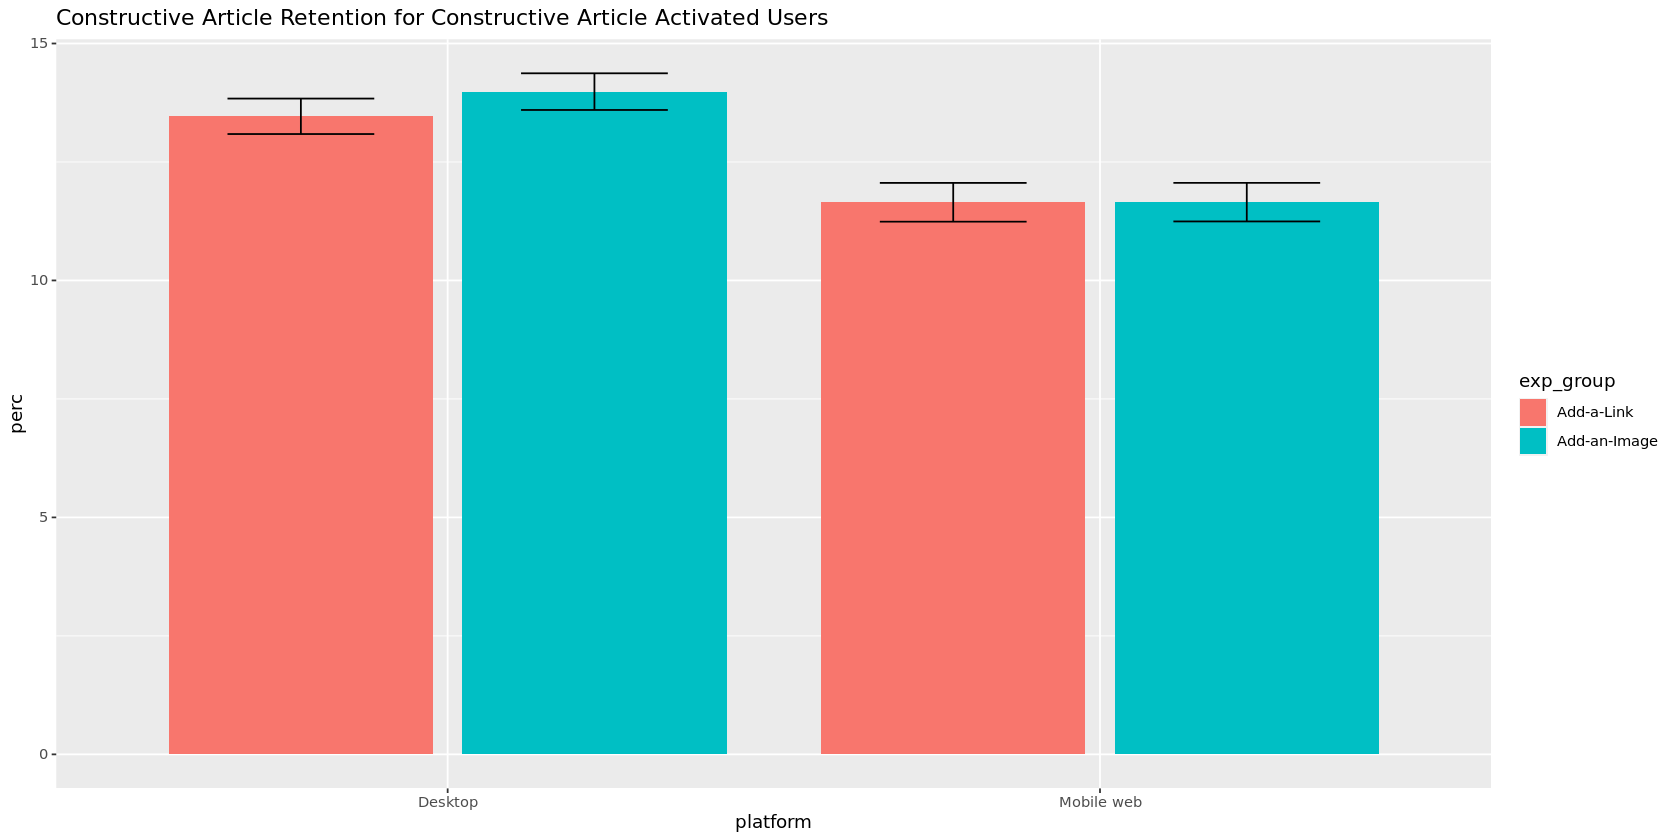

In [21]:
user_edit_data %>%
    filter(
        (exp_group != 'Control') &
        (is_const_activated_article == TRUE)
    ) %>%
    group_by(platform, exp_group, is_const_retained_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_retained_article == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = exp_group)) +
        labs(title = 'Constructive Article Retention for Constructive Article Activated Users') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

# Fitting Models

## Retention

In [24]:
blas_set_num_threads(16)
retention.overall.1 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_retained ~ platform + exp_group + is_activated + log_num_edits_24hrs + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [25]:
summary(retention.overall.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_retained ~ platform + exp_group + is_activated + log_num_edits_24hrs +  
    (1 | wiki_db)
   Data: filter(user_data_train, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   22718    22784   -11352    22704    88227 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-2.942 -0.281  0.000  0.000  4.095 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0142   0.119   
Number of obs: 88234, groups:  wiki_db, 6

Fixed effects:
                      Estimate Std. Error z value             Pr(>|z|)    
(Intercept)           -20.4185     1.3828  -14.77 < 0.0000000000000002 ***
platformMobile web     -0.2839     0.0359   -7.90   0.0000000000000028 ***
exp_groupAdd-a-Link     0.0430     0.0480    0.90                 0.37    
exp_groupAdd-an-Image   0.0141     0.0482    0.29                 0.77    
is_a

This model reflects the graphs fairly well. There's not a significant difference between the groups, and the estimated coefficients are similar to those in the graph.

Let's check for interaction between `platform` and `exp_group`:

In [27]:
blas_set_num_threads(16)
retention.overall.2 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_retained ~ platform * exp_group + is_activated + log_num_edits_24hrs + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [28]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.overall.2, c("theta", "fixef"))
blas_set_num_threads(16)
retention.overall.2 = update(retention.overall.2, start = start_vals,
                             control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

In [29]:
summary(retention.overall.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_retained ~ platform * exp_group + is_activated + log_num_edits_24hrs +  
    (1 | wiki_db)
   Data: filter(user_data_train, (wiki_db != "frwiki"))
Control: glmerControl(optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
   22721    22805   -11352    22703    88225 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-2.954 -0.282  0.000  0.000  4.157 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0142   0.119   
Number of obs: 88234, groups:  wiki_db, 6

Fixed effects:
                                          Estimate Std. Error z value
(Intercept)                              -20.39504    4.00891   -5.09
platformMobile web                        -0.34642    0.07959   -4.35
exp_groupAdd-a-Link                        0.00591    0.06909    0.09
exp_groupAdd-an-Image                     -0.

We don't find conclusive evidence of interaction. The BIC is worse and none of the predictors involving `exp_group` are significant. Let's move our attention to group-level effects.

In [30]:
blas_set_num_threads(16)
retention.overall.3 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_retained ~ platform + Group + is_activated + log_num_edits_24hrs +
                    (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [31]:
summary(retention.overall.3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform + Group + is_activated + log_num_edits_24hrs +  
    (1 + platform | wiki_db)
   Data: filter(user_data_train, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   22714    22789   -11349    22698    88226 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-2.997 -0.283  0.000  0.000  4.393 

Random effects:
 Groups  Name               Variance Std.Dev. Corr 
 wiki_db (Intercept)        0.0722   0.269         
         platformMobile web 0.0706   0.266    -0.90
Number of obs: 88234, groups:  wiki_db, 6

Fixed effects:
                    Estimate Std. Error z value            Pr(>|z|)    
(Intercept)         -21.5019     1.0980  -19.58 <0.0000000000000002 ***
platformMobile web   -0.1917     0.1202   -1.60                0.11    
GroupHP               0.0292     0.0439    0.66                0.51    
is_acti

Unlike activation, there does not appear to be a meaningful per-wiki level of variation when it comes to retention. The model isn't singular, which means there is data, but the AIC/BIC suggests there isn't significant improvement in the model fitness. This finding is not surprising, we've seen it before. It points to variation from wiki to wiki being encoded in the activation variables.

We'll check for group-level variation in the `exp_group` variable. From previous analyses we've not seen significance here, but it's important to check.

In [32]:
blas_set_num_threads(16)
retention.overall.4 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_retained ~ platform + exp_group + is_activated + log_num_edits_24hrs +
                    (1 + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see help('isSingular')



This model is singular, so we discard it. No indication of a meaningful variation between wikis when it comes to the effect of `exp_group`. Let's see if there's a variation in the effect of first day activity (which we've seen before in other analyses).

In [33]:
blas_set_num_threads(16)
retention.overall.5 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_retained ~ platform + exp_group + is_activated + log_num_edits_24hrs +
                    (1 + log_num_edits_24hrs | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [34]:
summary(retention.overall.5)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_retained ~ platform + exp_group + is_activated + log_num_edits_24hrs +  
    (1 + log_num_edits_24hrs | wiki_db)
   Data: filter(user_data_train, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   22716    22800   -11349    22698    88225 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-2.788 -0.283  0.000  0.000  4.081 

Random effects:
 Groups  Name                Variance Std.Dev. Corr 
 wiki_db (Intercept)         0.02168  0.1473        
         log_num_edits_24hrs 0.00927  0.0963   -0.63
Number of obs: 88234, groups:  wiki_db, 6

Fixed effects:
                      Estimate Std. Error z value             Pr(>|z|)    
(Intercept)           -20.3779     1.8658  -10.92 < 0.0000000000000002 ***
platformMobile web     -0.2906     0.0361   -8.05   0.0000000000000008 ***
exp_groupAdd-a-Link     0.0421     0.0480    0.88  

In [35]:
ranef(retention.overall.5)

$wiki_db
       (Intercept) log_num_edits_24hrs
arwiki     -0.1567             0.14662
bnwiki      0.0122            -0.10235
cswiki      0.0787             0.01968
fawiki      0.1606            -0.00775
ptwiki     -0.1529             0.00729
trwiki      0.0646            -0.06479

with conditional variances for “wiki_db” 

This model converges and isn't singular, which suggests that there is some variation. The output of `ranef` also shows this, where we see Arabic and Bangla having fairly substantial and opposing estimates. We can also see that for many of the other wikis, there is not a large effect relative to the population-level estimate.

### Overall Retention Not Conditioned on Activation

This takes activation and level of activity during the first day out of the question, to see if we increase overall retention.

In [49]:
blas_set_num_threads(16)
retention.overall.10 <-
    glmer(
        formula = is_retained ~ platform + Group + (1 | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [50]:
summary(retention.overall.10)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform + Group + (1 | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
   42500    42547   -21245    42490   104140 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.320 -0.253 -0.238 -0.200  5.446 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0569   0.239   
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                  Estimate Std. Error z value            Pr(>|z|)    
(Intercept)        -2.6700     0.0838  -31.84 <0.0000000000000002 ***
platformmobile     -0.3993     0.0297  -13.46 <0.0000000000000002 ***
GroupUnstructured   0.0151     0.0381    0.40               0.692    
GroupAdd-a-link     0.0694     0.0378    1.84               0.067 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        

The Add a Link group is marginally significant. Given that we didn't find a significant increase in retention when controlling for activation, this suggests that we are indeed increasing retention through increasing activation. This effect might be stronger for constructive article retention.

In [51]:
blas_set_num_threads(16)
retention.overall.11 <-
    glmer(
        formula = is_retained ~ platform * Group + (1 | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [52]:
summary(retention.overall.11)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform * Group + (1 | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
   42501    42568   -21244    42487   104138 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.321 -0.253 -0.239 -0.200  5.565 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0569   0.238   
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                                 Estimate Std. Error z value
(Intercept)                       -2.6392     0.0865  -30.50
platformmobile                    -0.4739     0.0635   -7.46
GroupUnstructured                 -0.0324     0.0496   -0.65
GroupAdd-a-link                    0.0394     0.0492    0.80
platformmobile:GroupUnstructured   0.1146     0.0774    1.48
platformmobile:GroupAdd-a-link     0.0730     0.0767    0.95
                             

No indication of interaction. I'll leave it here and check retention between the two task types, then move to article retention, rather than dig into per-wiki variation.

### Add an Image compared to Add a Link

In [36]:
blas_set_num_threads(16)
retention.overall.structured.1 <-
    user_data_train |>
    filter(exp_group != 'Control') |>
    glmer(
        formula = is_retained ~ platform + exp_group + is_activated + log_num_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [37]:
summary(retention.overall.structured.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_retained ~ platform + exp_group + is_activated + log_num_edits_24hrs +  
    (1 | wiki_db)
   Data: filter(user_data_train, exp_group != "Control")

     AIC      BIC   logLik deviance df.resid 
   27552    27609   -13770    27540   101115 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.186 -0.285  0.000  0.000  4.136 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0118   0.108   
Number of obs: 101121, groups:  wiki_db, 7

Fixed effects:
                       Estimate Std. Error z value            Pr(>|z|)    
(Intercept)           -20.41112    0.92935  -21.96 <0.0000000000000002 ***
platformMobile web     -0.32631    0.03369   -9.69 <0.0000000000000002 ***
exp_groupAdd-an-Image   0.00488    0.03154    0.15                0.88    
is_activatedTRUE       17.29975    0.92944   18.61 <0.0000000000000002 ***
lo

No indication that retention is different between the two structured tasks.

## Article Retention

In [38]:
blas_set_num_threads(16)
retention.article.1 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_retained_article ~ platform + exp_group +
                    is_activated_article + log_num_article_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [39]:
summary(retention.article.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained_article ~ platform + exp_group + is_activated_article +  
    log_num_article_edits_24hrs + (1 | wiki_db)
   Data: filter(user_data_train, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   16699    16765    -8342    16685    88227 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
 -2.73   0.00   0.00   0.00   4.06 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0222   0.149   
Number of obs: 88234, groups:  wiki_db, 6

Fixed effects:
                            Estimate Std. Error z value             Pr(>|z|)
(Intercept)                 -21.4041     2.2964   -9.32 < 0.0000000000000002
platformMobile web           -0.2501     0.0422   -5.92    0.000000003213877
exp_groupAdd-a-Link          -0.0138     0.0561   -0.25                 0.81
exp_groupAdd-an-Image        -0.0612     0.0564 

No difference between the groups when it comes to overall article retention.

In [42]:
blas_set_num_threads(16)
retention.article.2 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_retained_article ~ platform * exp_group +
                    is_activated_article + log_num_article_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [43]:
summary(retention.article.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained_article ~ platform * exp_group + is_activated_article +  
    log_num_article_edits_24hrs + (1 | wiki_db)
   Data: filter(user_data_train, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   16702    16786    -8342    16684    88225 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
 -2.73   0.00   0.00   0.00   4.06 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0222   0.149   
Number of obs: 88234, groups:  wiki_db, 6

Fixed effects:
                                         Estimate Std. Error z value
(Intercept)                              -21.3691     1.3011  -16.42
platformMobile web                        -0.3306     0.0930   -3.56
exp_groupAdd-a-Link                       -0.0721     0.0810   -0.89
exp_groupAdd-an-Image                     -0.1068     0.0818   -1.31
is_activate

No indication of an interaction effect here. The BIC is worse and none of the variables are significant.

In [44]:
blas_set_num_threads(16)
retention.article.3 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_retained_article ~ platform + exp_group +
                    is_activated_article + log_num_article_edits_24hrs +
                    (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [45]:
summary(retention.article.3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained_article ~ platform + exp_group + is_activated_article +  
    log_num_article_edits_24hrs + (1 + platform | wiki_db)
   Data: filter(user_data_train, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   16698    16782    -8340    16680    88225 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
 -2.77   0.00   0.00   0.00   4.19 

Random effects:
 Groups  Name               Variance Std.Dev. Corr 
 wiki_db (Intercept)        0.0672   0.259         
         platformMobile web 0.0559   0.236    -0.83
Number of obs: 88234, groups:  wiki_db, 6

Fixed effects:
                            Estimate Std. Error z value             Pr(>|z|)
(Intercept)                 -22.4802     3.4620   -6.49       0.000000000084
platformMobile web           -0.1740     0.1149   -1.52                 0.13
exp_groupAdd-a-Link          -0.0129

In [46]:
ranef(retention.article.3)

$wiki_db
       (Intercept) platformMobile web
arwiki       0.222            -0.2145
bnwiki      -0.430             0.3863
cswiki       0.199            -0.1614
fawiki       0.228            -0.0208
ptwiki      -0.092            -0.1321
trwiki      -0.115             0.1370

with conditional variances for “wiki_db” 

The model isn't singular, which suggests there is some variation in the effect of `platform`. We can again see this in the output from `ranef`. The AIC/BIC suggests there's not a meaningful improvement in model fitness, so we discard this model.

In [48]:
blas_set_num_threads(16)
retention.article.4 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_retained_article ~ platform + exp_group +
                    is_activated_article + log_num_article_edits_24hrs +
                    (1 + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see help('isSingular')



In [ ]:
summary(retention.article.4)

In [50]:
blas_set_num_threads(16)
retention.article.5 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_retained_article ~ platform + exp_group +
                    is_activated_article + log_num_article_edits_24hrs +
                    (1 + log_num_article_edits_24hrs | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see help('isSingular')



In [ ]:
summary(retention.article.5)

These models were also singular, so we discard them as well.

### Constructive Retention Overall

In [51]:
blas_set_num_threads(16)
retention.constr.overall.1 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_retained ~ platform + exp_group +
                    is_const_activated + log_num_const_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [52]:
summary(retention.constr.overall.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained ~ platform + exp_group + is_const_activated +  
    log_num_const_edits_24hrs + (1 | wiki_db)
   Data: filter(user_data_train, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   18402    18468    -9194    18388    88227 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.699 -0.254  0.000  0.000  4.337 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0237   0.154   
Number of obs: 88234, groups:  wiki_db, 6

Fixed effects:
                          Estimate Std. Error z value             Pr(>|z|)    
(Intercept)               -20.4328     1.5268  -13.38 < 0.0000000000000002 ***
platformMobile web         -0.2781     0.0402   -6.93      0.0000000000043 ***
exp_groupAdd-a-Link         0.0688     0.0535    1.29                 0.20    
exp_groupAdd-an-Image       0.0345     0.0538 

We do not find significant effects of the structured task relative to the control group in this first model, and so we check interaction between `exp_group` and `platform`:

In [56]:
blas_set_num_threads(16)
retention.constr.overall.2 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_retained ~ platform * exp_group +
                    is_const_activated + log_num_const_edits_24hrs + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [57]:
summary(retention.constr.overall.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained ~ platform * exp_group + is_const_activated +  
    log_num_const_edits_24hrs + (1 | wiki_db)
   Data: filter(user_data_train, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   18404    18488    -9193    18386    88225 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.747 -0.255  0.000  0.000  4.465 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0237   0.154   
Number of obs: 88234, groups:  wiki_db, 6

Fixed effects:
                                         Estimate Std. Error z value
(Intercept)                              -20.3831     2.3121   -8.82
platformMobile web                        -0.3904     0.0891   -4.38
exp_groupAdd-a-Link                        0.0172     0.0742    0.23
exp_groupAdd-an-Image                     -0.0495     0.0752   -0.66
is_const_activate

It's not clear that there's an interaction effect here. Given that we've previously seen platform-specific differences, we might want to split the analysis out like we did for activation, but that might be more interesting when we look at the Article & Talk namespaces.

In [58]:
blas_set_num_threads(16)
retention.constr.overall.3 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_retained ~ platform + exp_group +
                    is_const_activated + log_num_const_edits_24hrs + (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [59]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.constr.overall.3, c("theta", "fixef"))
blas_set_num_threads(16)
retention.constr.overall.3 = update(retention.constr.overall.3, start = start_vals,
                                    control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

In [60]:
summary(retention.constr.overall.3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained ~ platform + exp_group + is_const_activated +  
    log_num_const_edits_24hrs + (1 + platform | wiki_db)
   Data: filter(user_data_train, (wiki_db != "frwiki"))
Control: glmerControl(optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
   18399    18483    -9190    18381    88225 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.692 -0.255  0.000  0.000  4.780 

Random effects:
 Groups  Name               Variance Std.Dev. Corr 
 wiki_db (Intercept)        0.1123   0.335         
         platformMobile web 0.0747   0.273    -0.97
Number of obs: 88234, groups:  wiki_db, 6

Fixed effects:
                          Estimate Std. Error z value             Pr(>|z|)    
(Intercept)               -21.5087     3.6104   -5.96         0.0000000026 ***
platformMobile web         -0.1987     0.1256   -1.58        

The model is not singular, suggesting there is some variation around the popuplation level mean for `platform`. The BIC is worse, indicating that there isn't enough variation to warrant the added complexity. Hence we discard this model too.

In [61]:
blas_set_num_threads(16)
retention.constr.overall.4 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_retained ~ platform + exp_group +
                    is_const_activated + log_num_const_edits_24hrs + (1 + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [63]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.constr.overall.4, c("theta", "fixef"))
blas_set_num_threads(16)
retention.constr.overall.4 = update(retention.constr.overall.4, start = start_vals,
                                    control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00585172 (tol = 0.002, component 1)”


In [ ]:
summary(retention.constr.overall.4)

This model doesn't converge, so we discard it.

In [66]:
blas_set_num_threads(16)
retention.constr.overall.5 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_retained ~ platform + exp_group +
                    is_const_activated + log_num_const_edits_24hrs + (1 + log_num_const_edits_24hrs | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [67]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.constr.overall.5, c("theta", "fixef"))
blas_set_num_threads(16)
retention.constr.overall.5 = update(retention.constr.overall.5, start = start_vals,
                                    control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00530879 (tol = 0.002, component 1)”


In [ ]:
summary(retention.constr.overall.5)

This model also doesn't converge, so we discard it.

### Constructive Article Retention

In [68]:
blas_set_num_threads(16)
retention.constr.article.1 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group +
                    is_const_activated_article + log_num_const_article_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [69]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.constr.article.1, c("theta", "fixef"))
blas_set_num_threads(16)
retention.constr.article.1 = update(retention.constr.article.1, start = start_vals,
                                    control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

In [70]:
summary(retention.constr.article.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_const_retained_article ~ platform + exp_group + is_const_activated_article +  
    log_num_const_article_edits_24hrs + (1 | wiki_db)
   Data: filter(user_data_train, (wiki_db != "frwiki"))
Control: glmerControl(optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
   12534    12600    -6260    12520    88227 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
 -3.52   0.00   0.00   0.00   4.17 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0314   0.177   
Number of obs: 88234, groups:  wiki_db, 6

Fixed effects:
                                   Estimate Std. Error z value
(Intercept)                       -28.31406    6.40825   -4.42
platformMobile web                 -0.22294    0.04892   -4.56
exp_groupAdd-a-Link                 0.00268    0.06497    0.04
exp_groupAdd-an-Image          

In [71]:
blas_set_num_threads(16)
retention.constr.article.2 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_retained_article ~ platform * exp_group +
                    is_const_activated_article + log_num_const_article_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [73]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.constr.article.2, c("theta", "fixef"))
blas_set_num_threads(16)
retention.constr.article.2 = update(retention.constr.article.2, start = start_vals,
                                    control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

In [74]:
summary(retention.constr.article.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_const_retained_article ~ platform * exp_group + is_const_activated_article +  
    log_num_const_article_edits_24hrs + (1 | wiki_db)
   Data: filter(user_data_train, (wiki_db != "frwiki"))
Control: glmerControl(optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
   12537    12622    -6260    12519    88225 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
 -3.52   0.00   0.00   0.00   4.18 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0313   0.177   
Number of obs: 88234, groups:  wiki_db, 6

Fixed effects:
                                         Estimate Std. Error z value
(Intercept)                              -21.3737     2.3282   -9.18
platformMobile web                        -0.3228     0.1089   -2.96
exp_groupAdd-a-Link                       -0.0677     0.0893   -0.76
exp_gro

No indications of interactions here.

Checking whether allowing group-level variation in `platform` improves fitness:

In [75]:
blas_set_num_threads(16)
retention.constr.article.3 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group +
                    is_const_activated_article + log_num_const_article_edits_24hrs +
                    (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [76]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.constr.article.3, c("theta", "fixef"))
blas_set_num_threads(16)
retention.constr.article.3 = update(retention.constr.article.3, start = start_vals,
                                    control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


This model does not converge. Removing `is_const_activated_article` has worked to fix this earlier, so we'll fit two models. One similar to Model 1, but without the variable, and then one with group-level variation in `platform` so we can learn whether that improves fitness.

In [77]:
blas_set_num_threads(16)
retention.constr.article.4 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group +
                    log_num_const_article_edits_24hrs + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [78]:
summary(retention.constr.article.4)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_const_retained_article ~ platform + exp_group + log_num_const_article_edits_24hrs +  
    (1 | wiki_db)
   Data: filter(user_data_train, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   14401    14457    -7194    14389    88228 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-19.254  -0.092  -0.086  -0.075   8.201 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0836   0.289   
Number of obs: 88234, groups:  wiki_db, 6

Fixed effects:
                                  Estimate Std. Error z value
(Intercept)                       -4.82617    0.13758  -35.08
platformMobile web                -0.28072    0.05076   -5.53
exp_groupAdd-a-Link                0.00998    0.06714    0.15
exp_groupAdd-an-Image             -0.06189    0.06774   -0.91
log_num_const_article_edits_24hrs  2.05500    

It's not surprising that this model converges based on our previous experience with this. It's also not surprising that the AIC/BIC points to this model having considerably poorer fitness than Model 1. That being said, it allows us to compare to see if `platform` holds useful information at this point, so we do that:

In [79]:
blas_set_num_threads(16)
retention.constr.article.5 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group +
                    log_num_const_article_edits_24hrs + (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [80]:
summary(retention.constr.article.5)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_const_retained_article ~ platform + exp_group + log_num_const_article_edits_24hrs +  
    (1 + platform | wiki_db)
   Data: filter(user_data_train, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   14398    14473    -7191    14382    88226 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-19.190  -0.092  -0.085  -0.075   9.969 

Random effects:
 Groups  Name               Variance Std.Dev. Corr 
 wiki_db (Intercept)        0.280    0.529         
         platformMobile web 0.132    0.363    -0.97
Number of obs: 88234, groups:  wiki_db, 6

Fixed effects:
                                  Estimate Std. Error z value
(Intercept)                        -4.9322     0.2314  -21.32
platformMobile web                 -0.1771     0.1638   -1.08
exp_groupAdd-a-Link                 0.0105     0.0670    0.16
exp_groupAdd-an-Ima

The model is not singular, which suggests that there is group-level variation in this variable. At the same time, the AIC/BIC indicates that this is not a significantly better model than Model 4, so we conclude that we can remove the variable again.

Let's examine the other two variables:

In [81]:
blas_set_num_threads(16)
retention.constr.article.6 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group +
                    log_num_const_article_edits_24hrs + (1 + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see help('isSingular')



In [82]:
blas_set_num_threads(16)
retention.constr.article.7 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group +
                    log_num_const_article_edits_24hrs + (1 + log_num_const_article_edits_24hrs | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [83]:
summary(retention.constr.article.7)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_const_retained_article ~ platform + exp_group + log_num_const_article_edits_24hrs +  
    (1 + log_num_const_article_edits_24hrs | wiki_db)
   Data: filter(user_data_train, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   14376    14452    -7180    14360    88226 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-14.213  -0.098  -0.079  -0.073   7.811 

Random effects:
 Groups  Name                              Variance Std.Dev. Corr 
 wiki_db (Intercept)                       0.1026   0.32          
         log_num_const_article_edits_24hrs 0.0323   0.18     -0.49
Number of obs: 88234, groups:  wiki_db, 6

Fixed effects:
                                  Estimate Std. Error z value
(Intercept)                        -4.7801     0.1513  -31.60
platformMobile web                 -0.2939     0.0509   -5.77
exp_groupAd

In [84]:
ranef(retention.constr.article.7)

$wiki_db
       (Intercept) log_num_const_article_edits_24hrs
arwiki     -0.3945                           0.32692
bnwiki     -0.2579                          -0.18275
cswiki      0.3623                          -0.00406
fawiki      0.4251                          -0.13060
ptwiki     -0.0161                           0.03432
trwiki     -0.0902                          -0.05606

with conditional variances for “wiki_db” 

In [85]:
coef(retention.constr.article.7)

$wiki_db
       (Intercept) platformMobile web exp_groupAdd-a-Link exp_groupAdd-an-Image
arwiki       -5.17             -0.294              0.0101               -0.0643
bnwiki       -5.04             -0.294              0.0101               -0.0643
cswiki       -4.42             -0.294              0.0101               -0.0643
fawiki       -4.35             -0.294              0.0101               -0.0643
ptwiki       -4.80             -0.294              0.0101               -0.0643
trwiki       -4.87             -0.294              0.0101               -0.0643
       log_num_const_article_edits_24hrs
arwiki                              2.36
bnwiki                              1.85
cswiki                              2.03
fawiki                              1.91
ptwiki                              2.07
trwiki                              1.98

attr(,"class")
[1] "coef.mer"

This model is not singular, so there is some information available in this variable. The AIC suggests it's clearly better, while the BIC is less significant. Looking at the output of `ranef`, it's not clear that there's a lot of information and variation happening. It appears to be better to stick with Model 1, because retention hinges on activation, and so we choose that.

### Add an Image versus Add a Link

Because we're particularly interested in constructive article retention, we also fit models comparing the two structured tasks directly. This also allows us to add in French Wikipedia.

In [96]:
blas_set_num_threads(16)
retention.constr.article.struct.0 <- user_data_train |>
    filter(
        (wiki_db != 'frwiki') &
        (exp_group != 'Control')
    ) |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group +
                    is_const_activated_article + log_num_const_article_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [97]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.constr.article.struct.0, c("theta", "fixef"))
blas_set_num_threads(16)
retention.constr.article.struct.0 = update(retention.constr.article.struct.0, start = start_vals,
                                    control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

In [98]:
summary(retention.constr.article.struct.0)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_const_retained_article ~ platform + exp_group + is_const_activated_article +  
    log_num_const_article_edits_24hrs + (1 | wiki_db)
   Data: filter(user_data_train, (wiki_db != "frwiki") & (exp_group !=  
    "Control"))
Control: glmerControl(optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
   10192    10248    -5090    10180    70617 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
 -3.44   0.00   0.00   0.00   4.07 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0226   0.15    
Number of obs: 70623, groups:  wiki_db, 6

Fixed effects:
                                  Estimate Std. Error z value
(Intercept)                       -29.1762     4.9453   -5.90
platformMobile web                 -0.2030     0.0541   -3.75
exp_groupAdd-an-Image              -0.0621     0.0520   -1.20
is

In [90]:
blas_set_num_threads(16)
retention.constr.article.struct.1 <- user_data_train |>
    filter(
        (exp_group != 'Control')
    ) |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group +
                    is_const_activated_article + log_num_const_article_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [91]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.constr.article.struct.1, c("theta", "fixef"))
blas_set_num_threads(16)
retention.constr.article.struct.1 = update(retention.constr.article.struct.1, start = start_vals,
                                    control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

In [95]:
summary(retention.constr.article.struct.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_const_retained_article ~ platform + exp_group + is_const_activated_article +  
    log_num_const_article_edits_24hrs + (1 | wiki_db)
   Data: filter(user_data_train, (exp_group != "Control"))
Control: glmerControl(optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
   16071    16129    -8030    16059   101115 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
 -4.13   0.00   0.00   0.00   4.17 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0181   0.134   
Number of obs: 101121, groups:  wiki_db, 7

Fixed effects:
                                  Estimate Std. Error z value
(Intercept)                       -29.2123     2.4887  -11.74
platformMobile web                 -0.2651     0.0453   -5.85
exp_groupAdd-an-Image              -0.0018     0.0414   -0.04
is_const_activated_articleTRUE 

When we add French Wikipedia to the dataset, the difference between Add an Image and Add a Link becomes smaller. This suggests that there might be meaningful variation in how they function depending on the wiki we're looking at, maybe also the platform.

In [99]:
blas_set_num_threads(16)
retention.constr.article.struct.2 <- user_data_train |>
    filter(
        (exp_group != 'Control')
    ) |>
    glmer(
        formula = is_const_retained_article ~ platform * exp_group +
                    is_const_activated_article + log_num_const_article_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [100]:
summary(retention.constr.article.struct.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_const_retained_article ~ platform * exp_group + is_const_activated_article +  
    log_num_const_article_edits_24hrs + (1 | wiki_db)
   Data: filter(user_data_train, (exp_group != "Control"))

     AIC      BIC   logLik deviance df.resid 
   16073    16140    -8030    16059   101114 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
 -4.09   0.00   0.00   0.00   4.20 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0181   0.134   
Number of obs: 101121, groups:  wiki_db, 7

Fixed effects:
                                         Estimate Std. Error z value
(Intercept)                              -22.4493     2.1459  -10.46
platformMobile web                        -0.2397     0.0618   -3.88
exp_groupAdd-an-Image                      0.0185     0.0532    0.35
is_const_activated_articleTRUE            19.2086     2.1

No indication of an interaction effect between `platform` and `exp_group`. Let's look for group-level variation in the various variable we have.

In [101]:
blas_set_num_threads(16)
retention.constr.article.struct.3 <- user_data_train |>
    filter(
        (exp_group != 'Control')
    ) |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group +
                    is_const_activated_article + log_num_const_article_edits_24hrs +
                    (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [102]:
summary(retention.constr.article.struct.3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_const_retained_article ~ platform + exp_group + is_const_activated_article +  
    log_num_const_article_edits_24hrs + (1 + platform | wiki_db)
   Data: filter(user_data_train, (exp_group != "Control"))

     AIC      BIC   logLik deviance df.resid 
   16071    16147    -8028    16055   101113 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
 -4.11   0.00   0.00   0.00   4.29 

Random effects:
 Groups  Name               Variance Std.Dev. Corr 
 wiki_db (Intercept)        0.0611   0.247         
         platformMobile web 0.0344   0.186    -0.92
Number of obs: 101121, groups:  wiki_db, 7

Fixed effects:
                                   Estimate Std. Error z value
(Intercept)                       -22.49063    1.75225  -12.84
platformMobile web                 -0.20951    0.09387   -2.23
exp_groupAdd-an-Image              -0.00247    0.04138 

The model is not singular, but the amount of variation isn't big since the AIC/BIC doesn't improve.

In [103]:
blas_set_num_threads(16)
retention.constr.article.struct.4 <- user_data_train |>
    filter(
        (exp_group != 'Control')
    ) |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group +
                    is_const_activated_article + log_num_const_article_edits_24hrs +
                    (1 + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [104]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.constr.article.struct.4, c("theta", "fixef"))
blas_set_num_threads(16)
retention.constr.article.struct.4 = update(retention.constr.article.struct.4, start = start_vals,
                                    control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00220661 (tol = 0.002, component 1)”


In [ ]:
summary(retention.constr.article.struct.4)

This model doesn't converge, so we modify it by removing `is_const_activated_article`. This will most likely reduce the model fitness, as discussed earlier, but it will also allow us to see if there's variation in the effect of `exp_group`.

In [106]:
blas_set_num_threads(16)
retention.constr.article.struct.5 <- user_data_train |>
    filter(
        (exp_group != 'Control')
    ) |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group +
                    log_num_const_article_edits_24hrs +
                    (1 + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see help('isSingular')



This model is singular, indicating that there isn't significant variation, and so we discard it as well.

In [107]:
blas_set_num_threads(16)
retention.constr.article.struct.6 <- user_data_train |>
    filter(
        (exp_group != 'Control')
    ) |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group +
                    is_const_activated_article + log_num_const_article_edits_24hrs +
                    (1 + log_num_const_article_edits_24hrs | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [108]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.constr.article.struct.6, c("theta", "fixef"))
blas_set_num_threads(16)
retention.constr.article.struct.6 = update(retention.constr.article.struct.6, start = start_vals,
                                    control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

In [110]:
summary(retention.constr.article.struct.6)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_const_retained_article ~ platform + exp_group + is_const_activated_article +  
    log_num_const_article_edits_24hrs + (1 + log_num_const_article_edits_24hrs |  
    wiki_db)
   Data: filter(user_data_train, (exp_group != "Control"))
Control: glmerControl(optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
   16063    16139    -8024    16047   101113 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
 -3.37   0.00   0.00   0.00   4.06 

Random effects:
 Groups  Name                              Variance Std.Dev. Corr 
 wiki_db (Intercept)                       0.0442   0.210         
         log_num_const_article_edits_24hrs 0.0182   0.135    -0.78
Number of obs: 101121, groups:  wiki_db, 7

Fixed effects:
                                   Estimate Std. Error z value
(Intercept)                       -28.89358    2.07

In [111]:
ranef(retention.constr.article.struct.6)

$wiki_db
       (Intercept) log_num_const_article_edits_24hrs
arwiki    0.179144                           -0.0985
bnwiki    0.000267                           -0.1150
cswiki    0.016157                            0.0529
fawiki    0.261179                           -0.0464
frwiki   -0.239423                            0.1974
ptwiki   -0.222056                            0.0947
trwiki    0.019349                           -0.0900

with conditional variances for “wiki_db” 

In [112]:
coef(retention.constr.article.struct.6)

$wiki_db
       (Intercept) platformMobile web exp_groupAdd-an-Image
arwiki       -28.7             -0.264              -0.00154
bnwiki       -28.9             -0.264              -0.00154
cswiki       -28.9             -0.264              -0.00154
fawiki       -28.6             -0.264              -0.00154
frwiki       -29.1             -0.264              -0.00154
ptwiki       -29.1             -0.264              -0.00154
trwiki       -28.9             -0.264              -0.00154
       is_const_activated_articleTRUE log_num_const_article_edits_24hrs
arwiki                           25.7                             1.010
bnwiki                           25.7                             0.994
cswiki                           25.7                             1.162
fawiki                           25.7                             1.063
frwiki                           25.7                             1.306
ptwiki                           25.7                             1.204
trwiki 

The model is again not singular, suggesting that there's meaningful group-level variation around the population-level mean, but the AIC/BIC indicates that it doesn't significantly improve fitness. We therefore choose to discard this model and stick with Model 1.

## Models on the Full Dataset

### Overall Retention

In [113]:
blas_set_num_threads(16)
retention.overall.full <- user_edit_data |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_retained ~ platform + exp_group + is_activated + log_num_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [114]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.overall.full, c("theta", "fixef"))
blas_set_num_threads(16)
retention.overall.full = update(retention.overall.full, start = start_vals,
                                    control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

In [115]:
summary(retention.overall.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_retained ~ platform + exp_group + is_activated + log_num_edits_24hrs +  
    (1 | wiki_db)
   Data: filter(user_edit_data, (wiki_db != "frwiki"))
Control: glmerControl(optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
   28167    28234   -14076    28153   110382 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-2.980 -0.277  0.000  0.000  4.176 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0133   0.115   
Number of obs: 110389, groups:  wiki_db, 6

Fixed effects:
                      Estimate Std. Error z value            Pr(>|z|)    
(Intercept)           -26.9083     0.9247  -29.10 <0.0000000000000002 ***
platformMobile web     -0.2737     0.0323   -8.48 <0.0000000000000002 ***
exp_groupAdd-a-Link     0.0702     0.0434    1.62                0.11    
exp_groupAdd-an-Image   0.043

**Conclusion:** we do not find any significant difference in retention using all edits in all namespaces.

Comparing Add an Image to Add a Link:

In [116]:
blas_set_num_threads(16)
retention.overall.full.structured <- user_edit_data |>
    filter(
        (exp_group != 'Control')
    ) |>
    glmer(
        formula = is_retained ~ platform + exp_group + is_activated + log_num_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [117]:
summary(retention.overall.full.structured)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_retained ~ platform + exp_group + is_activated + log_num_edits_24hrs +  
    (1 | wiki_db)
   Data: filter(user_edit_data, (exp_group != "Control"))

     AIC      BIC   logLik deviance df.resid 
   34282    34340   -17135    34270   126395 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.145 -0.287  0.000  0.000  4.081 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0097   0.0985  
Number of obs: 126401, groups:  wiki_db, 7

Fixed effects:
                       Estimate Std. Error z value            Pr(>|z|)    
(Intercept)           -20.42769    1.00620  -20.30 <0.0000000000000002 ***
platformMobile web     -0.31214    0.03017  -10.35 <0.0000000000000002 ***
exp_groupAdd-an-Image  -0.00322    0.02828   -0.11                0.91    
is_activatedTRUE       17.31326    1.00580   17.21 <0.0000000000000002 ***
l

**Conclusion:** We do not find any significant difference in retention between the two structured tasks when using all edits across all namespaces.

In [ ]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.overall.agg <- user_edit_data %>%
    group_by(exp_group, is_retained) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(exp_group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.overall.agg

In [ ]:
## Calculate increase in percent
round(retention.overall.agg[4, "perc"] - retention.overall.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (retention.overall.agg[4, "perc"] - retention.overall.agg[2, "perc"]) /
        retention.overall.agg[2,"perc"], 1)

In [ ]:
## Calculate increase in percent
round(retention.overall.agg[6, "perc"] - retention.overall.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (retention.overall.agg[6, "perc"] - retention.overall.agg[2, "perc"]) /
        retention.overall.agg[2,"perc"], 1)

Same aggregation but based on users who activate:

In [ ]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.overall.activated.agg <- user_edit_data %>%
    filter(is_activated == TRUE) %>%
    group_by(Group, is_retained) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.overall.activated.agg

In [ ]:
## Calculate increase in percent
round(retention.overall.activated.agg[4, "perc"] - retention.overall.activated.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (retention.overall.activated.agg[4, "perc"] - retention.overall.activated.agg[2, "perc"]) /
        retention.overall.activated.agg[2,"perc"], 1)

In [ ]:
## Calculate increase in percent
round(retention.overall.activated.agg[6, "perc"] - retention.overall.activated.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (retention.overall.activated.agg[6, "perc"] - retention.overall.activated.agg[2, "perc"]) /
        retention.overall.activated.agg[2,"perc"], 1)

### Article & Talk namespace retention

In [119]:
blas_set_num_threads(16)
retention.article.full <- user_edit_data |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_retained_article ~ platform + exp_group +
                    is_activated_article + log_num_article_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [120]:
summary(retention.article.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained_article ~ platform + exp_group + is_activated_article +  
    log_num_article_edits_24hrs + (1 | wiki_db)
   Data: filter(user_edit_data, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   20816    20883   -10401    20802   110382 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
 -2.74   0.00   0.00   0.00   4.03 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0218   0.147   
Number of obs: 110389, groups:  wiki_db, 6

Fixed effects:
                            Estimate Std. Error z value             Pr(>|z|)
(Intercept)                 -21.4506     1.3992  -15.33 < 0.0000000000000002
platformMobile web           -0.2414     0.0378   -6.38        0.00000000018
exp_groupAdd-a-Link           0.0278     0.0508    0.55                 0.58
exp_groupAdd-an-Image        -0.0134     0.0511 

**Conclusion:** We do not find any difference in retention for all edits in the Article & Talk namespaces.

Comparing Add an Image to Add a Link:

In [121]:
blas_set_num_threads(16)
retention.article.full.structured <-
    user_edit_data |>
    filter(exp_group != 'Control') |>
    glmer(
        formula = is_retained_article ~ platform + exp_group +
                    is_activated_article + log_num_article_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [122]:
summary(retention.article.full.structured)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained_article ~ platform + exp_group + is_activated_article +  
    log_num_article_edits_24hrs + (1 | wiki_db)
   Data: filter(user_edit_data, exp_group != "Control")

     AIC      BIC   logLik deviance df.resid 
   25834    25892   -12911    25822   126395 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.224 -0.243  0.000  0.000  4.129 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0173   0.132   
Number of obs: 126401, groups:  wiki_db, 7

Fixed effects:
                              Estimate Std. Error z value             Pr(>|z|)
(Intercept)                 -21.450444   0.701276  -30.59 < 0.0000000000000002
platformMobile web           -0.289848   0.035453   -8.18  0.00000000000000029
exp_groupAdd-an-Image         0.000762   0.032673    0.02                 0.98
is_activated_articleTRUE     18.320939 

**Conclusion:** We find no significant difference between the two structured tasks when using all edits in the Article & Talk namespaces.

In [ ]:
blas_set_num_threads(16)
retention.article.full.noactivation <-
    glmer(
        formula = is_retained_article ~ platform + Group + (1 | wiki_db),
        data = user_edit_data,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(retention.article.full.noactivation)

In [ ]:
blas_set_num_threads(16)
retention.article.full.noactivation.growth <-
    user_edit_data %>%
    filter(Group != 'Control') %>%
    glmer(
        formula = is_retained_article ~ platform + Group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(retention.article.full.noactivation.growth)

In [ ]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.article.agg <- user_edit_data %>%
    group_by(Group, is_retained_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.article.agg

In [ ]:
## Calculate increase in percent
round(retention.article.agg[4, "perc"] - retention.article.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (retention.article.agg[4, "perc"] - retention.article.agg[2, "perc"]) /
        retention.article.agg[2,"perc"], 1)

In [ ]:
## Calculate increase in percent
round(retention.article.agg[6, "perc"] - retention.article.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (retention.article.agg[6, "perc"] - retention.article.agg[2, "perc"]) /
        retention.article.agg[2,"perc"], 1)

Same aggregation but based on users who activate:

In [ ]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.article.activated.agg <- user_edit_data %>%
    filter(is_activated_article == TRUE) %>%
    group_by(Group, is_retained_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.article.activated.agg

In [ ]:
## Calculate increase in percent
round(retention.article.activated.agg[4, "perc"] - retention.article.activated.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (retention.article.activated.agg[4, "perc"] - retention.article.activated.agg[2, "perc"]) /
        retention.article.activated.agg[2,"perc"], 1)

In [ ]:
## Calculate increase in percent
round(retention.article.activated.agg[6, "perc"] - retention.article.activated.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (retention.article.activated.agg[6, "perc"] - retention.article.activated.agg[2, "perc"]) /
        retention.article.activated.agg[2,"perc"], 1)

### Overall Constructive Retention

In [124]:
blas_set_num_threads(16)
retention.constr.overall.full <- user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_retained ~ platform + exp_group + is_const_activated + 
                    log_num_const_edits_24hrs + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [125]:
summary(retention.constr.overall.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained ~ platform + exp_group + is_const_activated +  
    log_num_const_edits_24hrs + (1 | wiki_db)
   Data: filter(user_data_train, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   18402    18468    -9194    18388    88227 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.699 -0.254  0.000  0.000  4.337 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0237   0.154   
Number of obs: 88234, groups:  wiki_db, 6

Fixed effects:
                          Estimate Std. Error z value             Pr(>|z|)    
(Intercept)               -20.4328     1.5268  -13.38 < 0.0000000000000002 ***
platformMobile web         -0.2781     0.0402   -6.93      0.0000000000043 ***
exp_groupAdd-a-Link         0.0688     0.0535    1.29                 0.20    
exp_groupAdd-an-Image       0.0345     0.0538 

**Conclusion:** We do not find a significant difference when using constructive (non-reverted) edits across all namespaces.

In [ ]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.overall.constr.agg <- user_edit_data %>%
    group_by(exp_group, is_const_retained) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(exp_group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.overall.constr.agg

In [ ]:
## Calculate increase in percent
round(retention.overall.constr.agg[4, "perc"] - retention.overall.constr.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (retention.overall.constr.agg[4, "perc"] - retention.overall.constr.agg[2, "perc"]) /
        retention.overall.constr.agg[2,"perc"], 1)

In [ ]:
## Calculate increase in percent
round(retention.overall.constr.agg[6, "perc"] - retention.overall.constr.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (retention.overall.constr.agg[6, "perc"] - retention.overall.constr.agg[2, "perc"]) /
        retention.overall.constr.agg[2,"perc"], 1)

Same aggregation but based on users who constructively activate:

In [ ]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.overall.const_activated.agg <- user_edit_data %>%
    filter(is_const_activated == TRUE) %>%
    group_by(exp_group, is_const_retained) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(exp_group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.overall.const_activated.agg

In [ ]:
## Calculate increase in percent
round(retention.overall.const_activated.agg[4, "perc"] - retention.overall.const_activated.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (retention.overall.const_activated.agg[4, "perc"] - retention.overall.const_activated.agg[2, "perc"]) /
        retention.overall.const_activated.agg[2,"perc"], 1)

In [ ]:
## Calculate increase in percent
round(retention.overall.const_activated.agg[6, "perc"] - retention.overall.const_activated.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (retention.overall.const_activated.agg[6, "perc"] - retention.overall.const_activated.agg[2, "perc"]) /
        retention.overall.const_activated.agg[2,"perc"], 1)

Comparing Add an Image to Add a Link, including French Wikipedia:

In [128]:
blas_set_num_threads(16)
retention.constr.overall.structured <- user_edit_data |>
    filter(
        (exp_group != 'Control')
    ) |>
    glmer(
        formula = is_const_retained ~ platform + exp_group +
                    is_const_activated + log_num_const_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [129]:
summary(retention.constr.overall.structured)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained ~ platform + exp_group + is_const_activated +  
    log_num_const_edits_24hrs + (1 | wiki_db)
   Data: filter(user_edit_data, (exp_group != "Control"))

     AIC      BIC   logLik deviance df.resid 
   28540    28598   -14264    28528   126395 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.779 -0.261  0.000  0.000  4.176 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0107   0.103   
Number of obs: 126401, groups:  wiki_db, 7

Fixed effects:
                           Estimate Std. Error z value            Pr(>|z|)    
(Intercept)               -21.41489    1.12947  -18.96 <0.0000000000000002 ***
platformMobile web         -0.30320    0.03326   -9.11 <0.0000000000000002 ***
exp_groupAdd-an-Image      -0.00354    0.03097   -0.11                0.91    
is_const_activatedTRUE     18.23774    1.12

**Conclusion:** We find no difference in retention between Add an Image and Add a Link when we use constructive (non-reverted) edits across all namespaces.

### Constructive Article Retention

In [131]:
blas_set_num_threads(16)
retention.constr.article.full <- user_edit_data |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group +
                    is_const_activated_article + log_num_const_article_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [132]:
summary(retention.constr.article.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_const_retained_article ~ platform + exp_group + is_const_activated_article +  
    log_num_const_article_edits_24hrs + (1 | wiki_db)
   Data: filter(user_edit_data, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   15663    15730    -7824    15649   110382 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
 -3.57   0.00   0.00   0.00   4.27 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0318   0.178   
Number of obs: 110389, groups:  wiki_db, 6

Fixed effects:
                                  Estimate Std. Error z value
(Intercept)                       -21.4448     1.6739  -12.81
platformMobile web                 -0.2262     0.0438   -5.17
exp_groupAdd-a-Link                 0.0240     0.0588    0.41
exp_groupAdd-an-Image              -0.0159     0.0591   -0.27
is_const_activated_articleT

**Conclusion:** We find no significant difference in retention when using constructive (non-reverted) edits in the Article & Talk namespaces.

Comparing Add an Image to Add a Link, adding French Wikipedia:

In [133]:
blas_set_num_threads(16)
retention.constr.article.full.growth <-
    user_edit_data |>
    filter(exp_group != 'Control') |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group +
                    is_const_activated_article + log_num_const_article_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [134]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.constr.article.full.growth, c("theta", "fixef"))
blas_set_num_threads(16)
retention.constr.article.full.growth = update(retention.constr.article.full.growth, start = start_vals,
                                    control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00323525 (tol = 0.002, component 1)”


In [135]:
blas_set_num_threads(16)
retention.constr.article.full.growth <-
    user_edit_data |>
    filter(exp_group != 'Control') |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group + log_num_const_article_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [136]:
summary(retention.constr.article.full.growth)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_const_retained_article ~ platform + exp_group + log_num_const_article_edits_24hrs +  
    (1 | wiki_db)
   Data: filter(user_edit_data, exp_group != "Control")

     AIC      BIC   logLik deviance df.resid 
   22701    22750   -11345    22691   126396 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-19.499  -0.098  -0.088  -0.078   8.170 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.058    0.241   
Number of obs: 126401, groups:  wiki_db, 7

Fixed effects:
                                   Estimate Std. Error z value
(Intercept)                       -4.805488   0.101350  -47.41
platformMobile web                -0.371753   0.041807   -8.89
exp_groupAdd-an-Image              0.000971   0.038428    0.03
log_num_const_article_edits_24hrs  2.068165   0.022761   90.86
                                        

**Conclusion:** We find no difference in retention when comparing Add an Image to Add a Link using only constructive (non-reverted) edits in the Article & Talk namespaces.

In [137]:
blas_set_num_threads(16)
retention.constr.article.noactivation <- user_edit_data |>
    filter(wiki_db != 'frwiki') |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [138]:
summary(retention.constr.article.noactivation)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained_article ~ platform + exp_group + (1 | wiki_db)
   Data: filter(user_edit_data, wiki_db != "frwiki")

     AIC      BIC   logLik deviance df.resid 
   25833    25882   -12912    25823   110384 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.247 -0.190 -0.155 -0.128  9.538 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.217    0.465   
Number of obs: 110389, groups:  wiki_db, 6

Fixed effects:
                      Estimate Std. Error z value            Pr(>|z|)    
(Intercept)            -3.5244     0.1855  -19.00 <0.0000000000000002 ***
platformMobile web     -0.4030     0.0394  -10.23 <0.0000000000000002 ***
exp_groupAdd-a-Link     0.1441     0.0534    2.70               0.007 ** 
exp_groupAdd-an-Image   0.1175     0.0536    2.19               0.028 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.

In [139]:
blas_set_num_threads(16)
retention.constr.article.noactivation.2 <- user_edit_data |>
    filter(wiki_db != 'frwiki') |>
    glmer(
        formula = is_const_retained_article ~ platform * exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [140]:
summary(retention.constr.article.noactivation.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained_article ~ platform * exp_group + (1 | wiki_db)
   Data: filter(user_edit_data, wiki_db != "frwiki")

     AIC      BIC   logLik deviance df.resid 
   25834    25902   -12910    25820   110382 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.247 -0.187 -0.157 -0.128  9.875 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.216    0.465   
Number of obs: 110389, groups:  wiki_db, 6

Fixed effects:
                                         Estimate Std. Error z value
(Intercept)                               -3.4605     0.1924  -17.99
platformMobile web                        -0.5364     0.0877   -6.11
exp_groupAdd-a-Link                        0.0802     0.0727    1.10
exp_groupAdd-an-Image                      0.0234     0.0734    0.32
platformMobile web:exp_groupAdd-a-Link     0.1336     0.1046    1.

In [141]:
blas_set_num_threads(16)
retention.constr.article.noactivation.desktop <- user_edit_data |>
    filter(
        (wiki_db != 'frwiki') &
        (platform == 'Desktop')
    ) |>
    glmer(
        formula = is_const_retained_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [142]:
summary(retention.constr.article.noactivation.desktop)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained_article ~ exp_group + (1 | wiki_db)
   Data: 
filter(user_edit_data, (wiki_db != "frwiki") & (platform == "Desktop"))

     AIC      BIC   logLik deviance df.resid 
   12463    12498    -6228    12455    46738 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.267 -0.194 -0.178 -0.127  8.295 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.336    0.58    
Number of obs: 46742, groups:  wiki_db, 6

Fixed effects:
                      Estimate Std. Error z value            Pr(>|z|)    
(Intercept)            -3.4869     0.2451  -14.23 <0.0000000000000002 ***
exp_groupAdd-a-Link     0.0818     0.0740    1.11                0.27    
exp_groupAdd-an-Image   0.0245     0.0747    0.33                0.74    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:


In [143]:
blas_set_num_threads(16)
retention.constr.article.noactivation.desktop.2 <- user_edit_data |>
    filter(
        (wiki_db != 'frwiki') &
        (platform == 'Desktop')
    ) |>
    glmer(
        formula = is_const_retained_article ~ exp_group + (1 + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see help('isSingular')



In [ ]:
summary(retention.constr.article.noactivation.desktop.2)

In [151]:
blas_set_num_threads(16)
retention.constr.article.noactivation.desktop.structured <- user_edit_data |>
    filter(
        (exp_group != 'Control') &
        (platform == 'Desktop')
    ) |>
    glmer(
        formula = is_const_retained_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [152]:
summary(retention.constr.article.noactivation.desktop.structured)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained_article ~ exp_group + (1 | wiki_db)
   Data: filter(user_edit_data, (exp_group != "Control") & (platform ==  
    "Desktop"))

     AIC      BIC   logLik deviance df.resid 
   19047    19074    -9521    19041    61914 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.259 -0.217 -0.191 -0.131  7.927 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.281    0.53    
Number of obs: 61917, groups:  wiki_db, 7

Fixed effects:
                      Estimate Std. Error z value            Pr(>|z|)    
(Intercept)            -3.3817     0.2048  -16.51 <0.0000000000000002 ***
exp_groupAdd-an-Image   0.0154     0.0430    0.36                0.72    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
exp_grpA--I -0.106

In [145]:
blas_set_num_threads(16)
retention.constr.article.noactivation.mobile <- user_edit_data |>
    filter(
        (wiki_db != 'frwiki') &
        (platform == 'Mobile web')
    ) |>
    glmer(
        formula = is_const_retained_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [146]:
summary(retention.constr.article.noactivation.mobile)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained_article ~ exp_group + (1 | wiki_db)
   Data: 
filter(user_edit_data, (wiki_db != "frwiki") & (platform == "Mobile web"))

     AIC      BIC   logLik deviance df.resid 
   13367    13403    -6679    13359    63643 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.203 -0.155 -0.139 -0.120  9.276 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.127    0.356   
Number of obs: 63647, groups:  wiki_db, 6

Fixed effects:
                      Estimate Std. Error z value            Pr(>|z|)    
(Intercept)            -4.0626     0.1627  -24.97 <0.0000000000000002 ***
exp_groupAdd-a-Link     0.2154     0.0779    2.77              0.0057 ** 
exp_groupAdd-an-Image   0.2168     0.0779    2.78              0.0054 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effect

In [147]:
blas_set_num_threads(16)
retention.constr.article.noactivation.mobile.2 <- user_edit_data |>
    filter(
        (wiki_db != 'frwiki') &
        (platform == 'Mobile web')
    ) |>
    glmer(
        formula = is_const_retained_article ~ exp_group + (1 + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see help('isSingular')



In [ ]:
summary(retention.constr.article.noactivation.mobile.2)

In [153]:
blas_set_num_threads(16)
retention.constr.article.noactivation.mobile.structured <- user_edit_data |>
    filter(
        (exp_group != 'Control') &
        (platform == 'Mobile web')
    ) |>
    glmer(
        formula = is_const_retained_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [154]:
summary(retention.constr.article.noactivation.mobile.structured)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained_article ~ exp_group + (1 | wiki_db)
   Data: filter(user_edit_data, (exp_group != "Control") & (platform ==  
    "Mobile web"))

     AIC      BIC   logLik deviance df.resid 
   13648    13676    -6821    13642    64481 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.200 -0.157 -0.140 -0.123  8.148 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.102    0.32    
Number of obs: 64484, groups:  wiki_db, 7

Fixed effects:
                      Estimate Std. Error z value            Pr(>|z|)    
(Intercept)            -3.8672     0.1290  -29.98 <0.0000000000000002 ***
exp_groupAdd-an-Image   0.0117     0.0533    0.22                0.83    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
exp_grpA--I -0.206

Examining only French Wikipedia:

In [33]:
blas_set_num_threads(16)
retention.constr.article.noactivation.frwiki <- user_edit_data |>
    filter(
        (wiki_db == 'frwiki') &
        (exp_group != 'Control')
    ) |>
    glm(
        formula = is_const_retained_article ~ platform + exp_group,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [34]:
summary(retention.constr.article.noactivation.frwiki)


Call:
glm(formula = is_const_retained_article ~ platform + exp_group, 
    family = binomial(link = "logit"), data = filter(user_edit_data, 
        (wiki_db == "frwiki") & (exp_group != "Control")))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.309  -0.309  -0.297  -0.202   2.825  

Coefficients:
                      Estimate Std. Error z value            Pr(>|z|)    
(Intercept)            -3.1020     0.0420  -73.89 <0.0000000000000002 ***
platformMobile web     -0.8696     0.0699  -12.44 <0.0000000000000002 ***
exp_groupAdd-an-Image   0.0850     0.0553    1.54                0.12    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 11743  on 38022  degrees of freedom
Residual deviance: 11561  on 38020  degrees of freedom
AIC: 11567

Number of Fisher Scoring iterations: 6


### Article Retention: Summary statistics

In [34]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.article.agg <- user_edit_data %>%
    filter(wiki_db != 'frwiki') |>
    group_by(platform, exp_group, is_retained_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(platform, exp_group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.article.agg

platform   exp_group    is_retained_article n     perc  rounded_perc
1  Desktop    Control      FALSE                9099 96.49 96.5        
2  Desktop    Control       TRUE                 331  3.51  3.5        
3  Desktop    Add-a-Link   FALSE               18038 96.25 96.3        
4  Desktop    Add-a-Link    TRUE                 702  3.75  3.7        
5  Desktop    Add-an-Image FALSE               17910 96.44 96.4        
6  Desktop    Add-an-Image  TRUE                 662  3.56  3.6        
7  Mobile web Control      FALSE               12232 97.23 97.2        
8  Mobile web Control       TRUE                 349  2.77  2.8        
9  Mobile web Add-a-Link   FALSE               24787 96.77 96.8        
10 Mobile web Add-a-Link    TRUE                 828  3.23  3.2        
11 Mobile web Add-an-Image FALSE               24633 96.79 96.8        
12 Mobile web Add-an-Image  TRUE                 818  3.21  3.2

Calculate increases in retention on mobile web between Add an Image and Control:

In [35]:
## Mobile web: absolute difference between Add an Image and Control:
round(retention.article.agg[12, "perc"] - retention.article.agg[8, "perc"], 1)

perc
1 0.4

In [36]:
## Calculate increase in percent
round(100 * (retention.article.agg[12, "perc"] - retention.article.agg[8, "perc"]) /
        retention.article.agg[8,"perc"], 1)

perc
1 15.9

In [37]:
## Mobile web: absolute difference between Add a Link and Control:
round(retention.article.agg[10, "perc"] - retention.article.agg[8, "perc"], 1)

perc
1 0.5

In [38]:
## Calculate increase in percent
round(100 * (retention.article.agg[10, "perc"] - retention.article.agg[8, "perc"]) /
        retention.article.agg[8,"perc"], 1)

perc
1 16.5

In [39]:
## Mobile web: absolute difference between Add an Image and Add a Link:
round(retention.article.agg[12, "perc"] - retention.article.agg[10, "perc"], 1)

perc
1 0

In [40]:
## Calculate increase in percent
round(100 * (retention.article.agg[12, "perc"] - retention.article.agg[10, "perc"]) /
        retention.article.agg[10,"perc"], 1)

perc
1 -0.6

Calculate increases in retention on desktop between Add an Image and Control:

In [41]:
## Desktop: absolute difference between Add an Image and Control:
round(retention.article.agg[6, "perc"] - retention.article.agg[2, "perc"], 1)

perc
1 0.1

In [42]:
## Calculate increase in percent
round(100 * (retention.article.agg[6, "perc"] - retention.article.agg[2, "perc"]) /
        retention.article.agg[2,"perc"], 1)

perc
1 1.6

In [43]:
## Desktop: absolute difference between Add a Link and Control:
round(retention.article.agg[4, "perc"] - retention.article.agg[2, "perc"], 1)

perc
1 0.2

In [44]:
## Calculate increase in percent
round(100 * (retention.article.agg[4, "perc"] - retention.article.agg[2, "perc"]) /
        retention.article.agg[2,"perc"], 1)

perc
1 6.7

In [39]:
## Mobile web: absolute difference between Add an Image and Add a Link:
round(retention.article.agg[12, "perc"] - retention.article.agg[10, "perc"], 1)

perc
1 0

In [40]:
## Calculate increase in percent
round(100 * (retention.article.agg[12, "perc"] - retention.article.agg[10, "perc"]) /
        retention.article.agg[10,"perc"], 1)

perc
1 -0.6

Difference in percentage points and relative difference between the two structured tasks:

In [45]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.article.agg.structured <- user_edit_data %>%
    filter(exp_group != 'Control') |>
    group_by(platform, exp_group, is_retained_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(platform, exp_group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.article.agg.structured

platform   exp_group    is_retained_article n     perc  rounded_perc
1 Desktop    Add-a-Link   FALSE               29814 95.73 95.7        
2 Desktop    Add-a-Link    TRUE                1330  4.27  4.3        
3 Desktop    Add-an-Image FALSE               29448 95.69 95.7        
4 Desktop    Add-an-Image  TRUE                1325  4.31  4.3        
5 Mobile web Add-a-Link   FALSE               31298 96.95 96.9        
6 Mobile web Add-a-Link    TRUE                 986  3.05  3.1        
7 Mobile web Add-an-Image FALSE               31213 96.93 96.9        
8 Mobile web Add-an-Image  TRUE                 987  3.07  3.1

### Constructive Article Retention: Summary statistics

In [25]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.article.constr.agg <- user_edit_data %>%
    filter(wiki_db != 'frwiki') |>
    group_by(platform, exp_group, is_const_retained_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(platform, exp_group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.article.constr.agg

platform   exp_group    is_const_retained_article n     perc  rounded_perc
1  Desktop    Control      FALSE                      9153 97.06 97.1        
2  Desktop    Control       TRUE                       277  2.94  2.9        
3  Desktop    Add-a-Link   FALSE                     18149 96.85 96.8        
4  Desktop    Add-a-Link    TRUE                       591  3.15  3.2        
5  Desktop    Add-an-Image FALSE                     18017 97.01 97.0        
6  Desktop    Add-an-Image  TRUE                       555  2.99  3.0        
7  Mobile web Control      FALSE                     12346 98.13 98.1        
8  Mobile web Control       TRUE                       235  1.87  1.9        
9  Mobile web Add-a-Link   FALSE                     25023 97.69 97.7        
10 Mobile web Add-a-Link    TRUE                       592  2.31  2.3        
11 Mobile web Add-an-Image FALSE                     24860 97.68 97.7        
12 Mobile web Add-an-Image  TRUE                       591  2.32  2.3

Calculate increases in retention on mobile web between Add an Image and Control:

In [27]:
## Mobile web: absolute difference between Add an Image and Control:
round(retention.article.constr.agg[12, "perc"] - retention.article.constr.agg[8, "perc"], 1)

perc
1 0.5

In [29]:
## Calculate increase in percent
round(100 * (retention.article.constr.agg[12, "perc"] - retention.article.constr.agg[8, "perc"]) /
        retention.article.constr.agg[8,"perc"], 1)

perc
1 24.3

In [30]:
## Mobile web: absolute difference between Add a Link and Control:
round(retention.article.constr.agg[10, "perc"] - retention.article.constr.agg[8, "perc"], 1)

perc
1 0.4

In [31]:
## Calculate increase in percent
round(100 * (retention.article.constr.agg[10, "perc"] - retention.article.constr.agg[8, "perc"]) /
        retention.article.constr.agg[8,"perc"], 1)

perc
1 23.7

In [32]:
## Mobile web: absolute difference between Add an Image and Add a Link:
round(retention.article.constr.agg[12, "perc"] - retention.article.constr.agg[10, "perc"], 1)

perc
1 0

In [33]:
## Calculate increase in percent
round(100 * (retention.article.constr.agg[12, "perc"] - retention.article.constr.agg[10, "perc"]) /
        retention.article.constr.agg[10,"perc"], 1)

perc
1 0.5

Calculate increases in retention on desktop between Add an Image and Control:

In [46]:
## Desktop: absolute difference between Add an Image and Control:
round(retention.article.constr.agg[6, "perc"] - retention.article.constr.agg[2, "perc"], 1)

perc
1 0.1

In [47]:
## Calculate increase in percent
round(100 * (retention.article.constr.agg[6, "perc"] - retention.article.constr.agg[2, "perc"]) /
        retention.article.constr.agg[2,"perc"], 1)

perc
1 1.7

In [49]:
## Desktop: absolute difference between Add a Link and Control:
round(retention.article.constr.agg[4, "perc"] - retention.article.constr.agg[2, "perc"], 1)

perc
1 0.2

In [50]:
## Calculate increase in percent
round(100 * (retention.article.constr.agg[4, "perc"] - retention.article.constr.agg[2, "perc"]) /
        retention.article.constr.agg[2, "perc"], 1)

perc
1 7.4

In [32]:
## Mobile web: absolute difference between Add an Image and Add a Link:
round(retention.article.constr.agg[12, "perc"] - retention.article.constr.agg[10, "perc"], 1)

perc
1 0

In [33]:
## Calculate increase in percent
round(100 * (retention.article.constr.agg[12, "perc"] - retention.article.constr.agg[10, "perc"]) /
        retention.article.constr.agg[10,"perc"], 1)

perc
1 0.5

Difference in percentage points and relative difference between the two structured tasks:

In [40]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.article.constr.agg.structured <- user_edit_data %>%
    filter(exp_group != 'Control') |>
    group_by(platform, exp_group, is_const_retained_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(platform, exp_group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.article.constr.agg.structured

platform   exp_group    is_const_retained_article n     perc  rounded_perc
1 Desktop    Add-a-Link   FALSE                     30021 96.39 96.4        
2 Desktop    Add-a-Link    TRUE                      1123  3.61  3.6        
3 Desktop    Add-an-Image FALSE                     29647 96.34 96.3        
4 Desktop    Add-an-Image  TRUE                      1126  3.66  3.7        
5 Mobile web Add-a-Link   FALSE                     31567 97.78 97.8        
6 Mobile web Add-a-Link    TRUE                       717  2.22  2.2        
7 Mobile web Add-an-Image FALSE                     31475 97.75 97.7        
8 Mobile web Add-an-Image  TRUE                       725  2.25  2.3

In [ ]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.article.constr.agg.frwiki <- user_edit_data %>%
    filter(
        (exp_group != 'Control') &
        (wiki_db == 'frwiki')
    ) |>
    group_by(platform, exp_group, is_const_retained_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(platform, exp_group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.article.constr.agg.frwiki

In [ ]:
# Aggregate across the entire dataset the proportion of registrations retained
user_edit_data %>%
    filter(
        (exp_group != 'Control') &
        (wiki_db == 'frwiki') &
        (is_const_activated_article)
    ) |>
    group_by(platform, exp_group, is_const_retained_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(platform, exp_group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))


In [17]:
## Calculate increase in percent
round(retention.article.constr.agg[4, "perc"] - retention.article.constr.agg[2, "perc"], 1)

perc
1 0.3

In [18]:
## Calculate increase in percent
round(100 * (retention.article.constr.agg[4, "perc"] - retention.article.constr.agg[2, "perc"]) /
        retention.article.constr.agg[2,"perc"], 1)

perc
1 9.9

In [19]:
## Calculate increase in percent
round(retention.article.constr.agg[6, "perc"] - retention.article.constr.agg[2, "perc"], 1)

perc
1 0.5

In [20]:
## Calculate increase in percent
round(100 * (retention.article.constr.agg[6, "perc"] - retention.article.constr.agg[2, "perc"]) /
        retention.article.constr.agg[2,"perc"], 1)

perc
1 16.2

Difference in percentage points and relative difference between the unstructured and structured task groups:

In [21]:
## Calculate increase in percent
round(retention.article.constr.agg[6, "perc"] - retention.article.constr.agg[4, "perc"], 1)

perc
1 0.2

In [22]:
## Calculate increase in percent
round(100 * (retention.article.constr.agg[6, "perc"] - retention.article.constr.agg[4, "perc"]) /
        retention.article.constr.agg[4,"perc"], 1)

perc
1 5.7

Same aggregation but based on users who constructively activate:

In [ ]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.article.const_activated.agg <- user_edit_data %>%
    filter(is_const_activated_article == TRUE) %>%
    group_by(platform, exp_group, is_const_retained_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(platform, exp_group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.article.const_activated.agg

In [ ]:
## Calculate increase in percent
round(retention.article.const_activated.agg[4, "perc"] - retention.article.const_activated.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (retention.article.const_activated.agg[4, "perc"] - retention.article.const_activated.agg[2, "perc"]) /
        retention.article.const_activated.agg[2,"perc"], 1)

In [ ]:
## Calculate increase in percent
round(retention.article.const_activated.agg[6, "perc"] - retention.article.const_activated.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (retention.article.const_activated.agg[6, "perc"] - retention.article.const_activated.agg[2, "perc"]) /
        retention.article.const_activated.agg[2,"perc"], 1)

# Graphs

## Article Retention

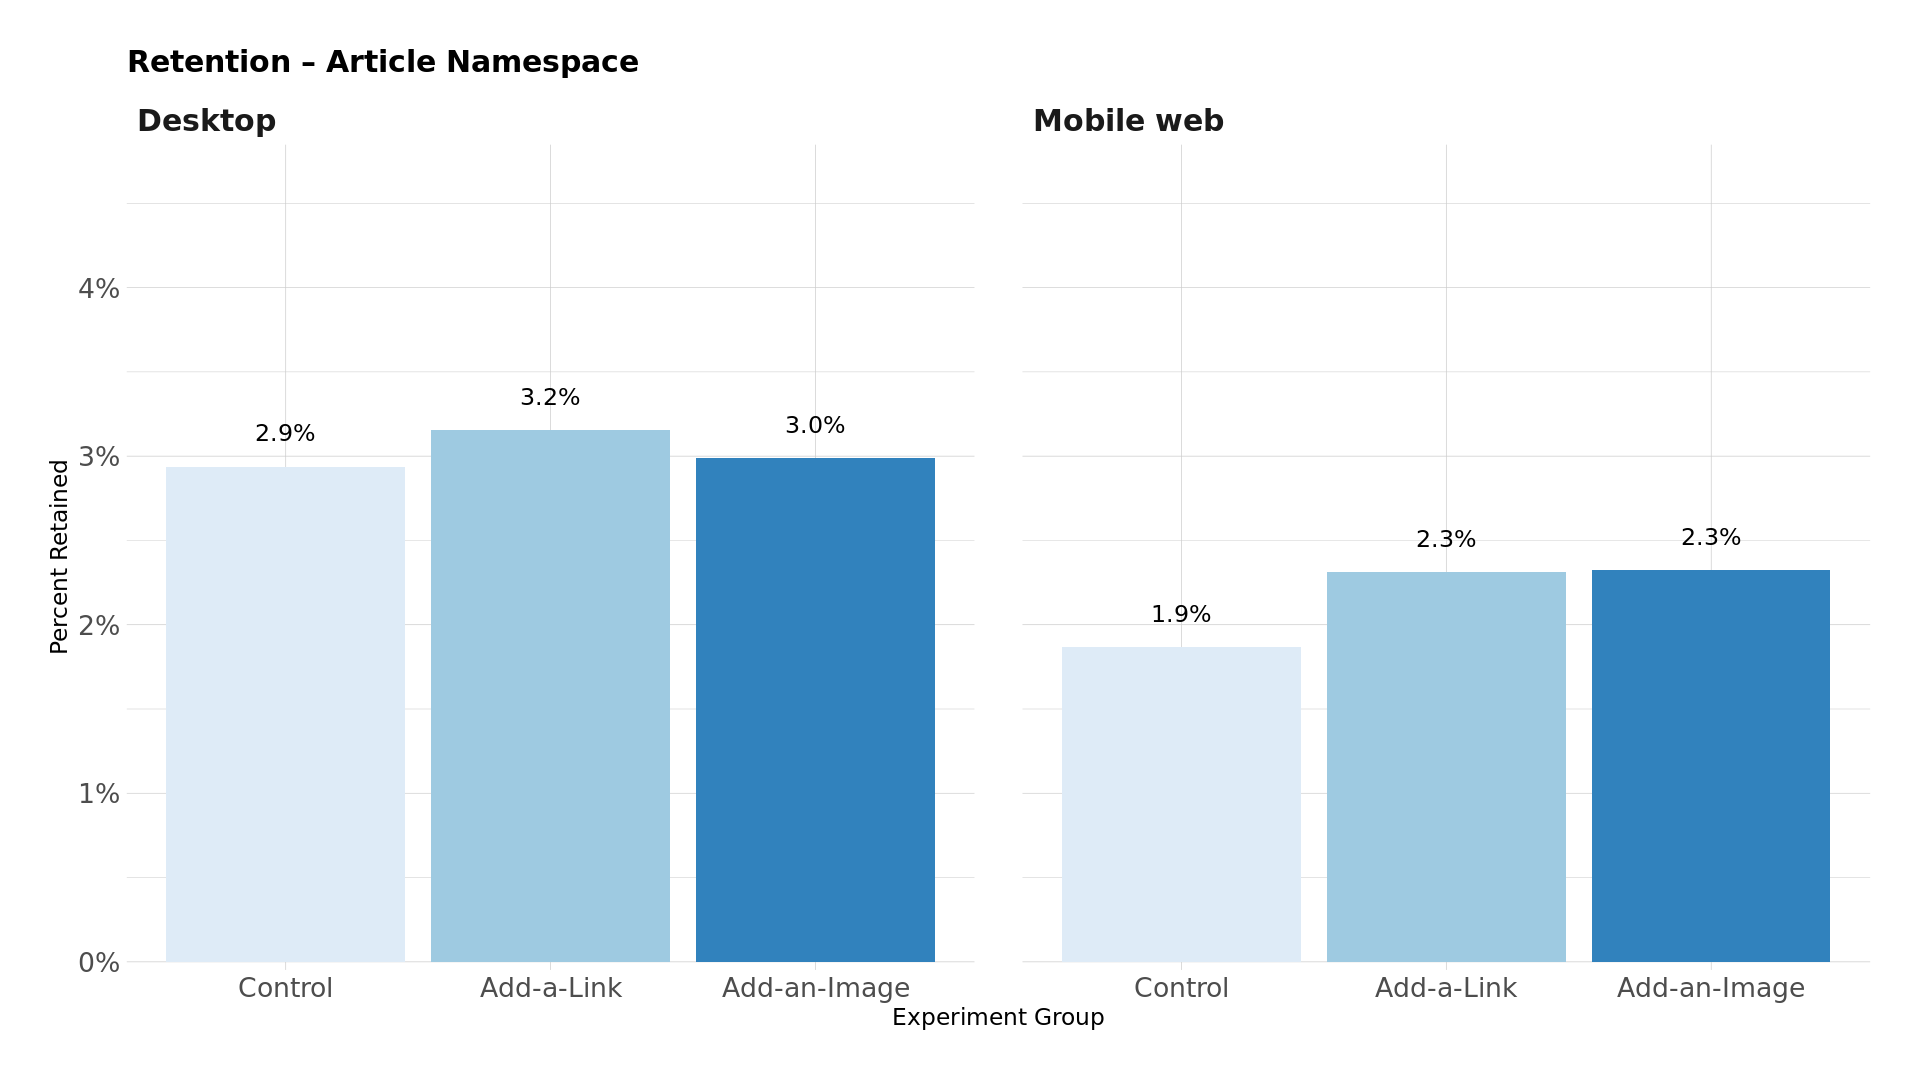

In [38]:
# Give me wider plots, please
options(repr.plot.width = 16, repr.plot.height = 9)
user_edit_data %>%
    filter(wiki_db != 'frwiki') |>
    group_by(platform, exp_group, is_const_retained_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    filter(is_const_retained_article == TRUE) %>%
    ggplot(aes(x = exp_group, y = prob, fill = exp_group)) +
        labs(title = 'Retention – Article Namespace', x = 'Experiment Group', y = 'Percent Retained') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        hrbrthemes::scale_y_percent(limits = c(0, 0.048)) +
        geom_col() +
        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.002, size = 5) +
        facet_grid(. ~ platform)
#ggsave(
#    'add-a-link-article-namespace-retention-2021-experiment.png',
#    path = 'graphs',
#    width = 9, height = 6, units = "in", dpi = "screen")

## Constructive Article Retention

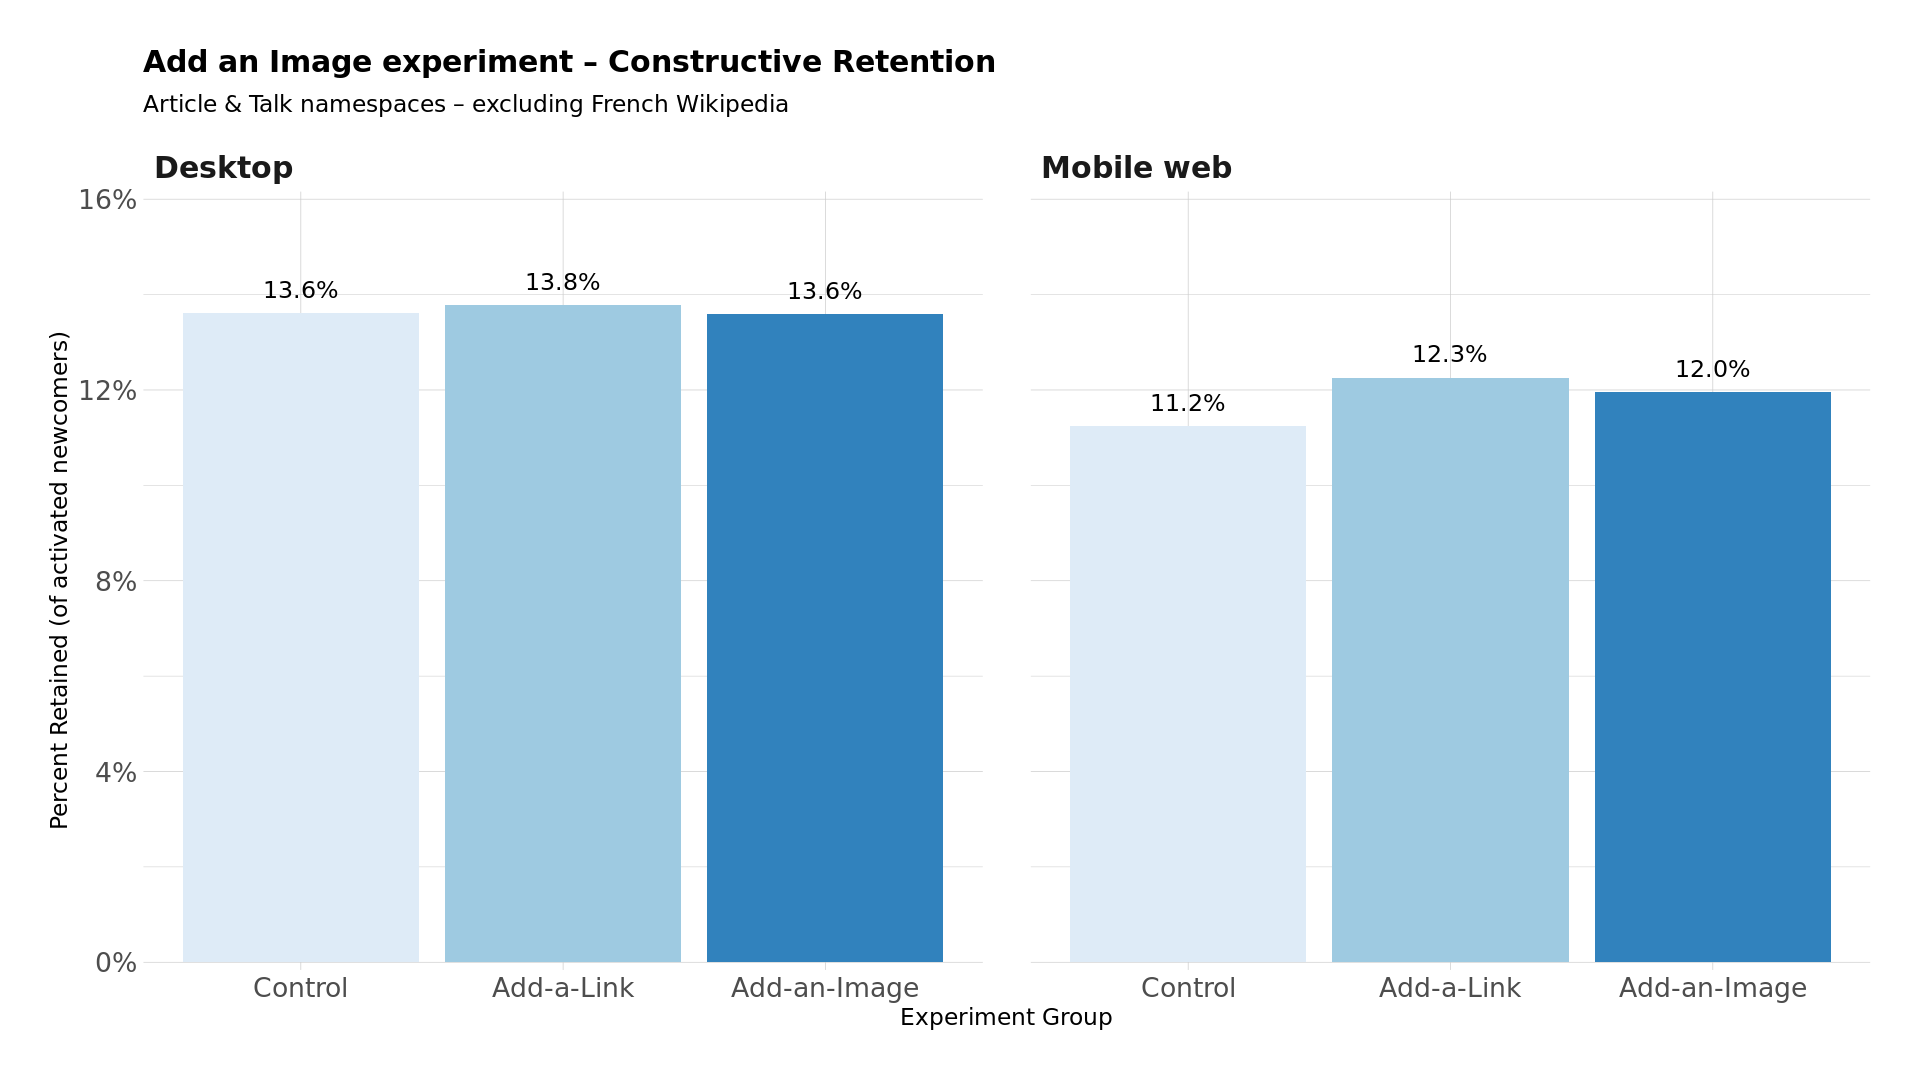

In [27]:
# Give me wider plots, please
options(repr.plot.width = 16, repr.plot.height = 9)
user_edit_data |>
    filter(
        (wiki_db != 'frwiki') &
        (is_const_activated_article == TRUE)
    ) |>
    group_by(platform, exp_group, is_const_retained_article) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(
        perc = 100 * n / per_group, prob = n / per_group,
        SE = sqrt(prob * (1 - prob) / per_group)
    ) |>
    filter(is_const_retained_article == TRUE) |>
    ggplot(aes(x = exp_group, y = prob, fill = exp_group)) +
        labs(
            title = 'Add an Image experiment – Constructive Retention',
            subtitle = 'Article & Talk namespaces – excluding French Wikipedia',
            x = 'Experiment Group',
            y = 'Percent Retained (of activated newcomers)') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        hrbrthemes::scale_y_percent(limits = c(0, 0.16)) +
        geom_col(position = 'dodge2') +
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.005, size = 5) +
        facet_grid(. ~ platform)
ggsave(
    'add-an-image-article-namespace-constructive-retention-2022-experiment.png',
    path = 'graphs',
    width = 16, height = 9, units = "in", dpi = "print", bg = "white")

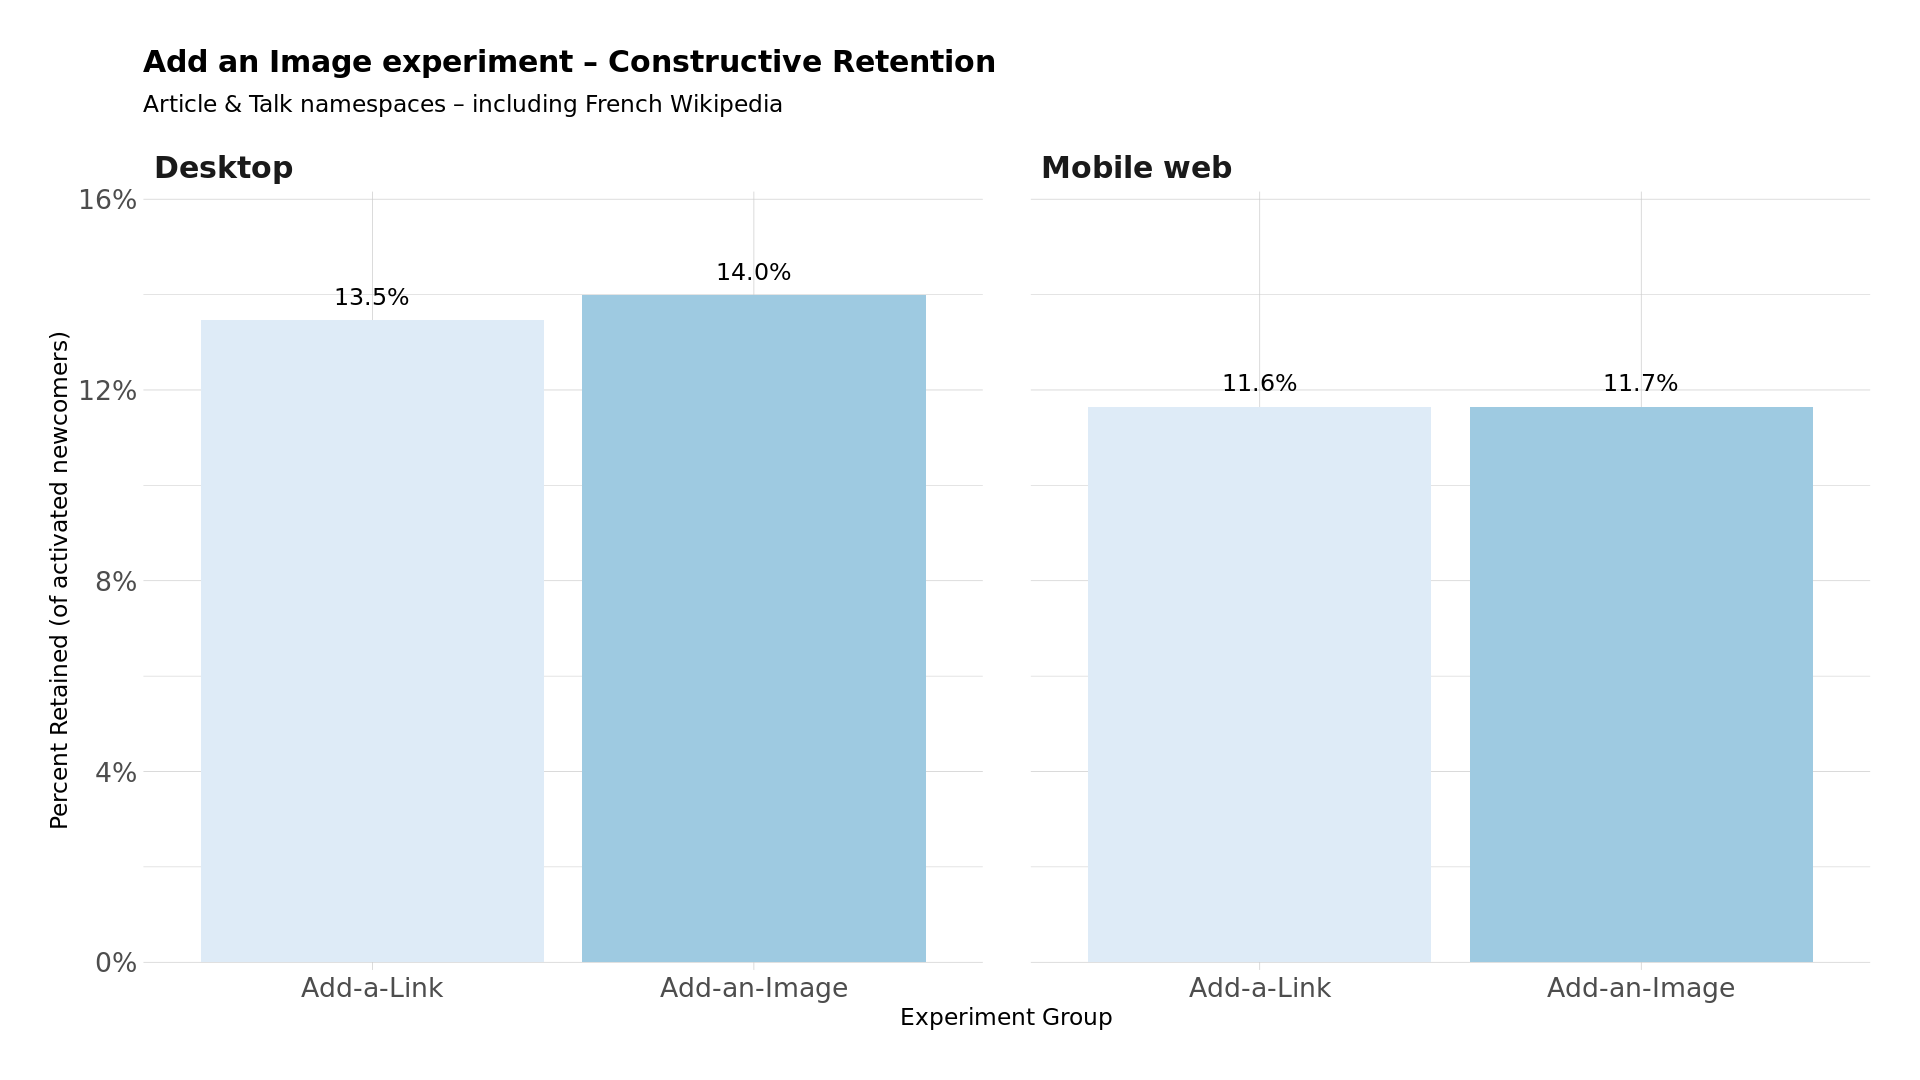

In [29]:
# Give me wider plots, please
options(repr.plot.width = 16, repr.plot.height = 9)
user_edit_data |>
    filter(
        (exp_group != 'Control') &
        (is_const_activated_article == TRUE)
    ) |>
    group_by(platform, exp_group, is_const_retained_article) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(
        perc = 100 * n / per_group, prob = n / per_group,
        SE = sqrt(prob * (1 - prob) / per_group)
    ) |>
    filter(is_const_retained_article == TRUE) |>
    ggplot(aes(x = exp_group, y = prob, fill = exp_group)) +
        labs(
            title = 'Add an Image experiment – Constructive Retention',
            subtitle = 'Article & Talk namespaces – including French Wikipedia',
            x = 'Experiment Group',
            y = 'Percent Retained (of activated newcomers)') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        hrbrthemes::scale_y_percent(limits = c(0, 0.16)) +
        geom_col(position = 'dodge2') +
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.005, size = 5) +
        facet_grid(. ~ platform)
ggsave(
    'add-an-image-article-namespace-constructive-retention-2022-experiment-structured-tasks.png',
    path = 'graphs',
    width = 16, height = 9, units = "in", dpi = "print", bg = "white")

### Constructive Article Retention out of All Registrations

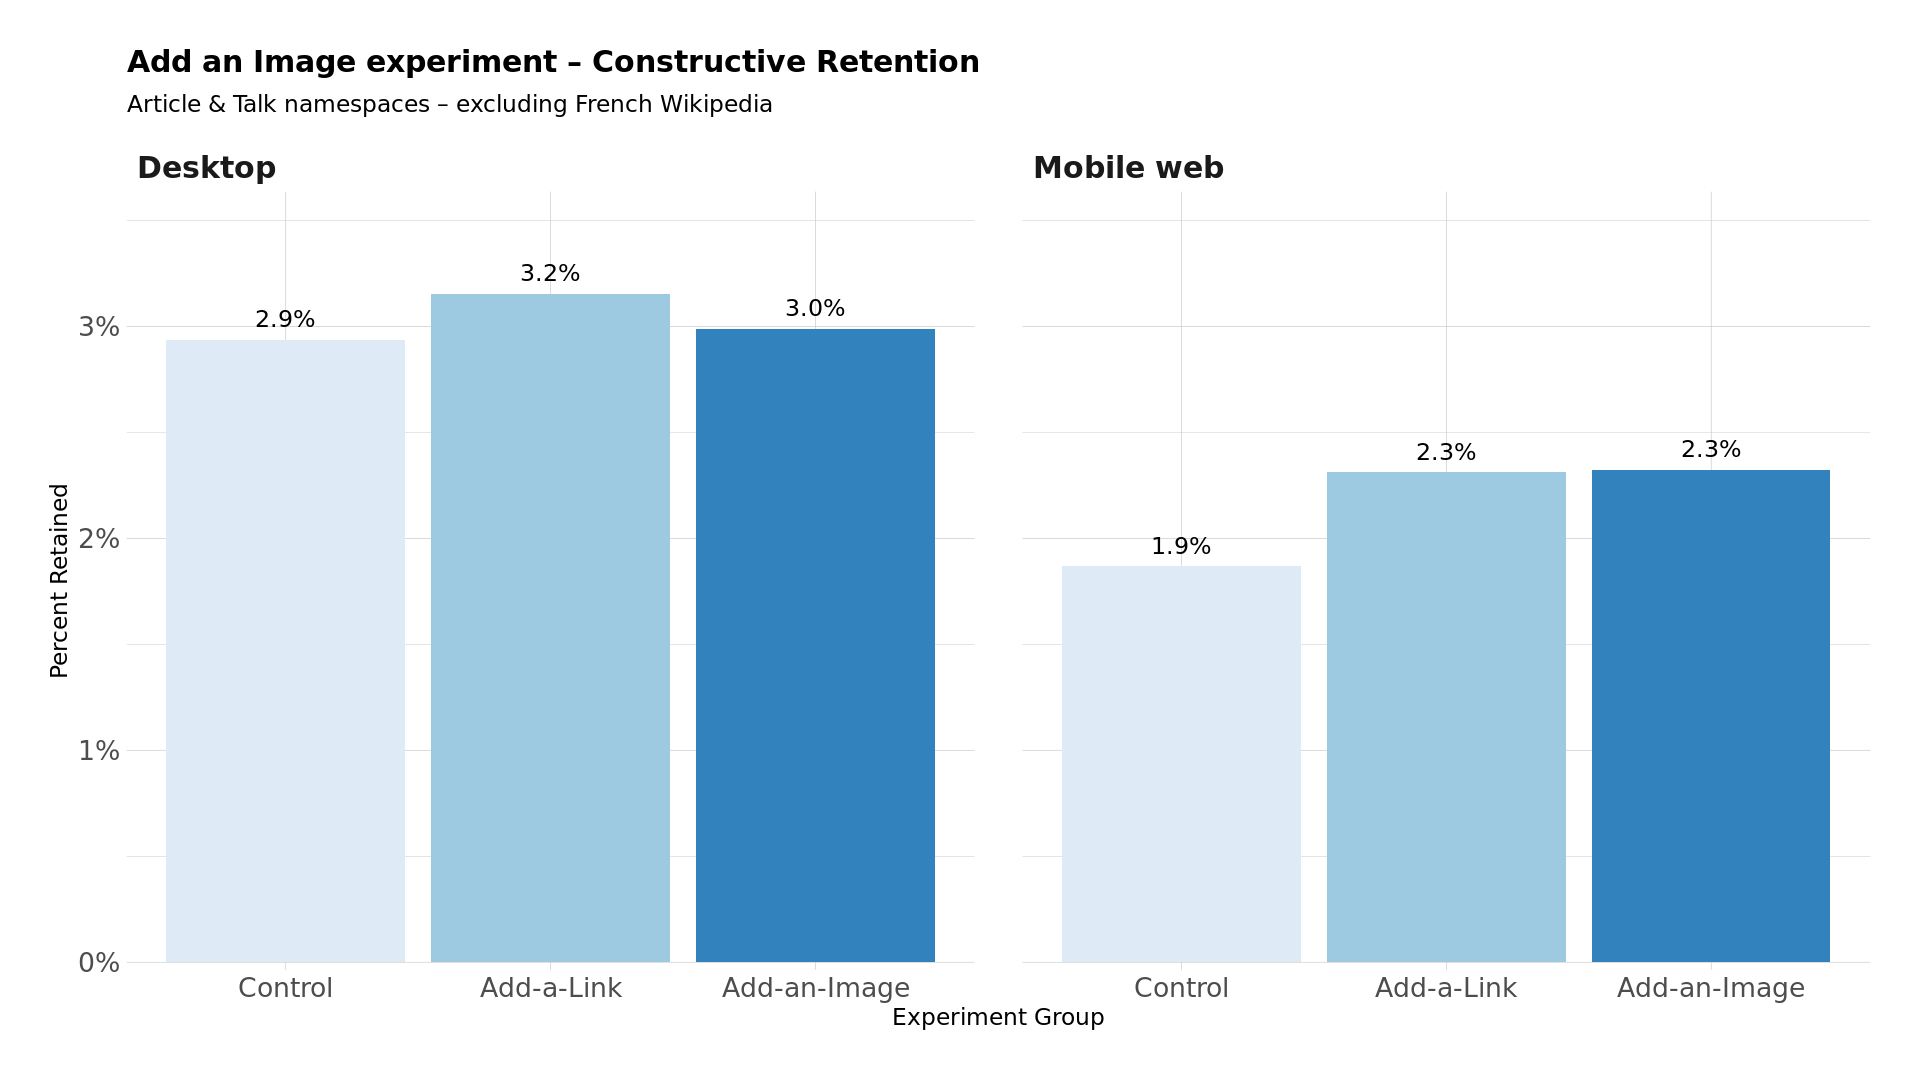

In [21]:
# Give me wider plots, please
options(repr.plot.width = 16, repr.plot.height = 9)
user_edit_data |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    group_by(platform, exp_group, is_const_retained_article) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(
        perc = 100 * n / per_group, prob = n / per_group,
        SE = sqrt(prob * (1 - prob) / per_group)
    ) |>
    filter(is_const_retained_article == TRUE) |>
    ggplot(aes(x = exp_group, y = prob, fill = exp_group)) +
        labs(
            title = 'Add an Image experiment – Constructive Retention',
            subtitle = 'Article & Talk namespaces – excluding French Wikipedia',
            x = 'Experiment Group',
            y = 'Percent Retained') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        hrbrthemes::scale_y_percent(limits = c(0, 0.036)) +
        geom_col(position = 'dodge2') +
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.001, size = 5) +
        facet_grid(. ~ platform)
ggsave(
    'add-an-image-article-namespace-constructive-retention-2022-experiment.png',
    path = 'graphs',
    width = 16, height = 9, units = "in", dpi = "print", bg = "white")

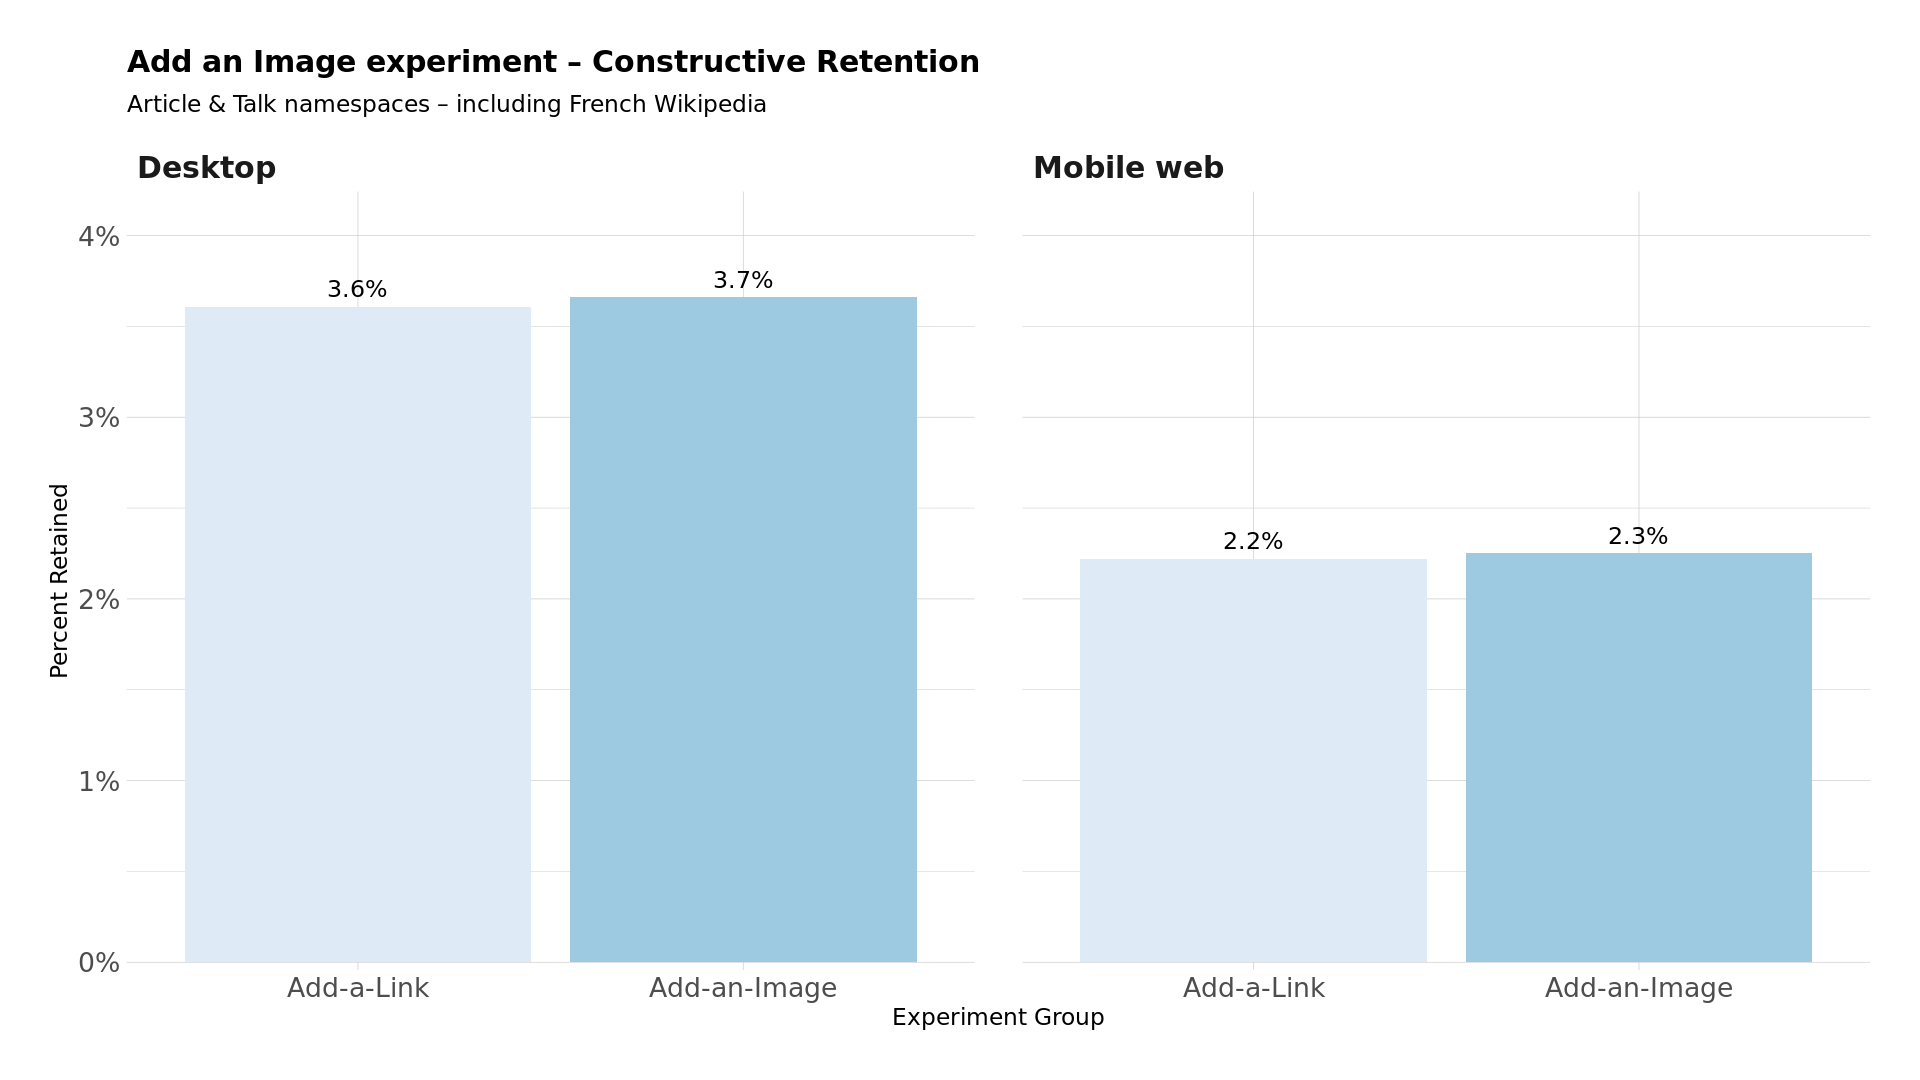

In [22]:
# Give me wider plots, please
options(repr.plot.width = 16, repr.plot.height = 9)
user_edit_data |>
    filter(
        (exp_group != 'Control')
    ) |>
    group_by(platform, exp_group, is_const_retained_article) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(
        perc = 100 * n / per_group, prob = n / per_group,
        SE = sqrt(prob * (1 - prob) / per_group)
    ) |>
    filter(is_const_retained_article == TRUE) |>
    ggplot(aes(x = exp_group, y = prob, fill = exp_group)) +
        labs(
            title = 'Add an Image experiment – Constructive Retention',
            subtitle = 'Article & Talk namespaces – including French Wikipedia',
            x = 'Experiment Group',
            y = 'Percent Retained') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        hrbrthemes::scale_y_percent(limits = c(0, 0.042)) +
        geom_col(position = 'dodge2') +
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.001, size = 5) +
        facet_grid(. ~ platform)
ggsave(
    'add-an-image-article-namespace-constructive-retention-2022-experiment-structured-tasks.png',
    path = 'graphs',
    width = 16, height = 9, units = "in", dpi = "print", bg = "white")